# Title

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from string import ascii_lowercase
import ipywidgets
import time

import discretize
from SimPEG import (
    Utils, Maps, Inversion, Regularization, DataMisfit, InvProblem,
    Optimization, Directives
)
from SimPEG import Problem, Survey, Props
from SimPEG import DC
from SimPEG.EM import TDEM
from pymatsolver import Pardiso

import casingSimulations as casingSim

%matplotlib inline

In [2]:
rcParams['font.size'] = 14

In [3]:
sim_dir = 'DC_halfspace'

## Model

- approximate the casing as a solid cylinder, conductivity equals to the conductivity thickness product
- use effective medium theory to estimate the conductivity of the target

In [4]:
# casing parameters
casing_l = 1000
sigma_back = 1e-2
casing_d = 10e-2
casing_t = 1e-2
sigma_casing = 5e6

sigma_casing_homogenized = sigma_casing * np.pi*((casing_d/2)**2 - (casing_d/2 - casing_t)**2)
print('The conductivity of the cylinder is {:1.2e} S/m'.format(sigma_casing_homogenized))

The conductivity of the cylinder is 1.41e+04 S/m


In [5]:
# proppant-fluid parameters
sigma_proppant = 1e4
sigma_fluid = 3
phi_proppant = 0.5

In [6]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant)
sigma_pf = (scemt * np.r_[phi_proppant])[0]
print('The conductivity of the proppant-fluid mixture is {:1.2f} S/m'.format(sigma_pf))

The conductivity of the proppant-fluid mixture is 2506.73 S/m


In [7]:
# fracture geometry
n_fracs = 10
fracture_thickness = 3e-3
fracture_width = 10. # 10m wide fracture zone
fracture_radius = 50.
fracture_top = -950.

In [8]:
V_total = np.pi * fracture_radius**2 * fracture_width 
V_frac = np.pi * fracture_radius**2 * fracture_thickness*n_fracs
phi_frac = V_frac/V_total

print("The concentration of fractures by volume is {}".format(phi_frac))

The concentration of fractures by volume is 0.003


In [9]:
alpha = (fracture_thickness*0.5)/50

print("We assume an aspect ratio of {}".format(alpha))

We assume an aspect ratio of 3e-05


In [10]:
scemt_fractures = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha
)

In [11]:
sigma_frac = (scemt_fractures * np.r_[phi_frac])[0]
print('The conductivity of the fractured region of rock is {:1.2f} S/m'.format(sigma_frac))

The conductivity of the fractured region of rock is 3.31 S/m


In [12]:
model = casingSim.model.CasingInHalfspaceWithTarget(
    directory=sim_dir,
    sigma_casing= sigma_casing_homogenized,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_casing_homogenized,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    sigma_target = sigma_frac,  # conductivity of the fractured region
    casing_d = casing_d-casing_d/2,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_d/4, 
    target_radius = np.r_[0., fracture_radius],
    target_z = fracture_top + np.r_[-fracture_width, 0.],
    src_a = np.r_[0., np.pi, -975.],  # put the A electrode just below the surface
    src_b = np.r_[2000., np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

In [13]:
model.serialize()

{'__class__': 'CasingInHalfspaceWithTarget',
 'casing_d': 0.05,
 'casing_l': 1000.0,
 'casing_t': 0.025,
 'casing_top': 0.0,
 'directory': 'DC_halfspace',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.01,
 'sigma_casing': 14137.166941154077,
 'sigma_inside': 14137.166941154077,
 'sigma_target': 3.306452089817292,
 'src_a': [0.0, 3.141592653589793, -975.0],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'target_radius': [0.0, 50.0],
 'target_theta': [0.0, 6.283185307179586],
 'target_z': [-960.0, -950.0],
 'version': '0.0.6'}

In [14]:
copied_model_params = copiedmodelparams = {
    key: val for key, val in model.serialize().items() 
    if key in dir(casingSim.model.CasingInHalfspace) and not key.startswith('_') 
}
background = casingSim.model.CasingInHalfspace(**copied_model_params)

In [15]:
model_names = ["background", "fracture"]
model_dict = {
    "background": background, 
    "fracture": model
}

## Mesh

In [16]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 9, 16  # number of padding cells
pfx2 = 1.5  # expansion factor for the padding to infinity in the x-direction
pfz = 1.5

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(1)
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=sim_dir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_b/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)
mesh = cylMeshGen.mesh

In [17]:
print("The mesh has {} cells".format(mesh.nC))

The mesh has 43316 cells


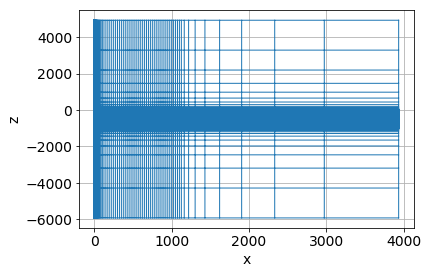

In [18]:
cylMeshGen.mesh.plotGrid()

## Physical Properties

In [19]:
phys_props_dict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, val) for key, val in model_dict.items()
}

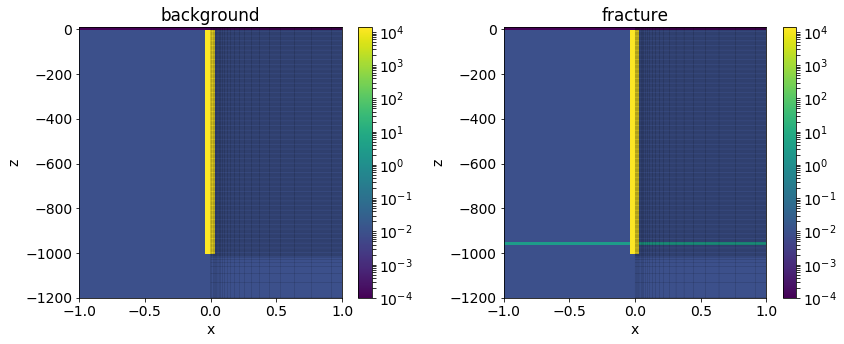

In [20]:
fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
xlim = 1*np.r_[-1, 1]
ylim = [-1200, 10]
plot_mesh = True

for a, key in zip(ax, model_names):
    phys_props_dict[key].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(key)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

## Survey

In [21]:
rx_x = np.linspace(25, 1000, 40)
rx_z = np.r_[-1.25]  # slightly below the surface for better interpolation 
rx_locs = Utils.ndgrid([rx_x, np.r_[0], rx_z])

rx_list = [DC.Rx.BaseRx(rx_locs, 'ex')]

In [22]:
include_obswell = False

if include_obswell is True:
    rx2_x = np.r_[250.]
    rx2_z = np.linspace(-1000, -25, 40)
    rx2_locs = Utils.ndgrid([rx2_x, np.r_[0.], rx2_z])
    
    rx_list += [DC.Rx.BaseRx(rx2_locs, 'ez')]

In [23]:
experiment = 4

if experiment == 1:
    z_locs = np.r_[-975] + cylMeshGen.csz/2
    src_a = np.atleast_2d(model.src_a)
    src_a[0, 2] = z_locs[0]
    src_b = np.atleast_2d(model.src_b)
    
elif experiment == 2:
    z_locs = -1*np.linspace(25, 975, 20) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

elif experiment == 3:
    z_locs = -1*np.linspace(25, 1000, 40) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

elif experiment == 4:
    z_locs = -1*np.linspace(900, 1000, 10) + cylMeshGen.csz/2
    src_a = np.vstack([np.r_[model.src_a[0], model.src_a[1], z] for z in z_locs])
    src_b = np.kron(np.ones((len(z_locs), 1)), model.src_b)

In [24]:
src_list = [DC.Src.Dipole(rx_list, locA=src_a[i, :], locB=src_b[i, :]) for i in range(len(z_locs))]

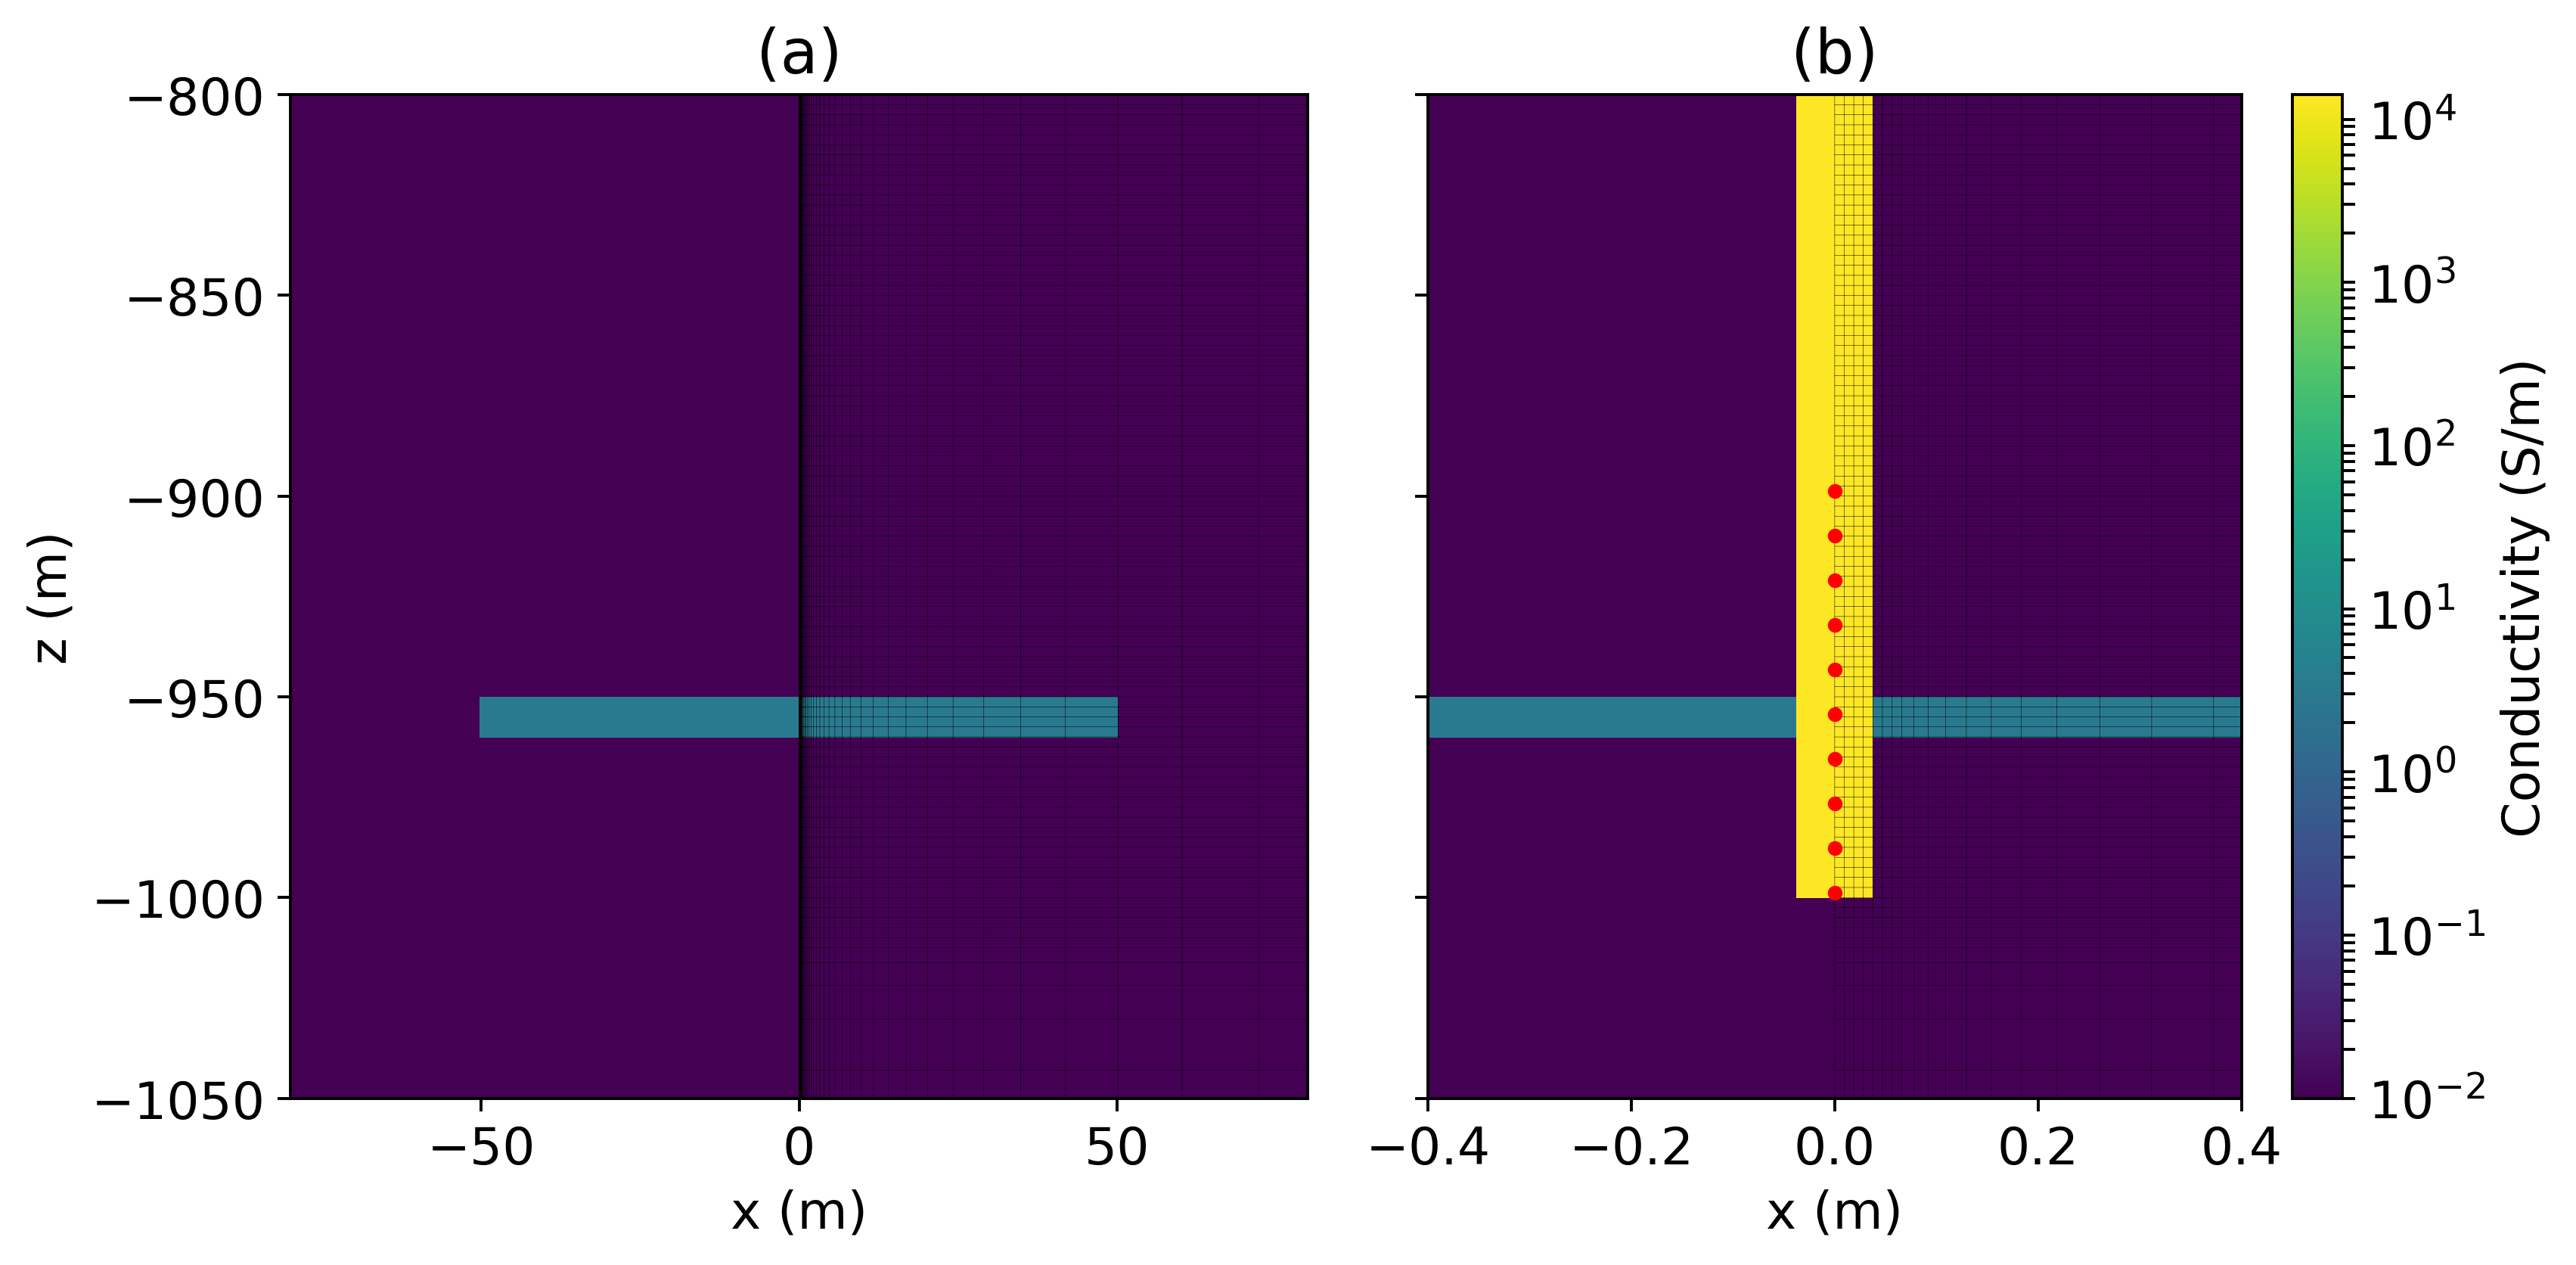

In [25]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5), dpi=350)
xlim_a = 0.4*np.r_[-1, 1]
xlim_b = 80*np.r_[-1, 1]
# ylim_a = [-1200, -800]
ylim = [-1050, -800]

plot_mesh = True
plot_sources = True

for i, a in enumerate(ax):
    out = phys_props_dict[key].plot_sigma(
        ax=a, pcolorOpts={'norm':LogNorm()}, show_cb=True if i==1 else False, clim=np.r_[sigma_back, sigma_casing_homogenized]
    )
    a.set_xlim(xlim_a if i == 1 else xlim_b)
    a.set_ylim(ylim)
    
    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)
    
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_ylabel("z (m)")
    a.set_xlabel("x (m)")
    
    if i == 1:
        out[-1].set_label("Conductivity (S/m)")
        a.set_ylabel('')
        a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if plot_sources:
            a.plot(np.zeros_like(z_locs), z_locs, 'ro', ms=3)

plt.tight_layout()
fig.savefig('../figures/DC_cyl_setup', dpi=350)

## Set up a DC simulation

In [26]:
prob_dict = {}
survey_dict = {}

for key in model_names:
    prob_dict[key] = DC.Problem3D_CC(
        mesh, sigmaMap=Maps.ExpMap(mesh), bc_type='Dirichlet', Solver=Pardiso
    )
    survey_dict[key] = DC.Survey(src_list)
    prob_dict[key].pair(survey_dict[key]) 

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [27]:
survey_dict["fracture"].nD

400

In [28]:
%%time
fields_dict = {}
for key in model_names:
    t = time.time()
    print('Running {}'.format(key))
    fields_dict[key] = prob_dict[key].fields(np.log(phys_props_dict[key].sigma))
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Running background
  ... elapsed time 3.75e-01 s

Running fracture
  ... elapsed time 2.91e-01 s

CPU times: user 1.01 s, sys: 79.5 ms, total: 1.09 s
Wall time: 669 ms


In [29]:
%%time
data_dict = {}
for key in model_names:
    t = time.time()
    print('Computing data for {}'.format(key))
    data_dict[key] = survey_dict[key].dpred(
        np.log(phys_props_dict[key].sigma), f=fields_dict[key]
    )
    print('  ... elapsed time {:1.2e} s\n'.format(time.time()-t))

Computing data for background
  ... elapsed time 6.92e-02 s

Computing data for fracture
  ... elapsed time 5.93e-02 s

CPU times: user 146 ms, sys: 9.77 ms, total: 156 ms
Wall time: 129 ms


In [30]:
def wrangle_data(data, component="x"):
    d = data.reshape(src_list[0].nD, len(src_list), order="F")
    if component == "x": 
        dx = d[:src_list[0].rxList[0].nD, :] 
        return dx
    
    if include_obswell and component == "z":
        dz = d[src_list[0].rxList[0].nD:, :]
        return dz
        
    data_dict[key] = entry

In [31]:
for key, value in data_dict.items():
    entry = {
        "data": value,
        "data_x": wrangle_data(value, "x")
    }
    if include_obswell:
        entry["data_z"] = wrangle_data(value, "z")
    data_dict[key] = entry

## Plot data

In [32]:
def plot_models(
    model, mapping, xlim=80*np.r_[-1, 1], ylim=[-1050, -800], 
    clim=None, plot_mesh=False, ax=None
):
    
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 

    out_true = phys_props_dict["fracture"].plot_sigma(
        ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
    )
    
    if clim is None:
        clim = [np.min(np.r_[sigma_back, np.exp(mrec.min())]), np.exp(mrec.max())]
        
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping * model, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
    )

    ax[0].set_title("true")
    ax[1].set_title("recovered")

    for a in ax:
        a.set_xlim(xlim)
        a.set_ylim(ylim)

        if plot_mesh:
            mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
            a.grid(None)

    plt.tight_layout()
    
    return (ax, out_true, out_rec)

In [33]:
from matplotlib import colors
from matplotlib import cm as cmap

In [34]:
cm = plt.get_cmap('magma')
c_norm = colors.Normalize(vmin=np.floor(0.99*(-z_locs).min()), vmax=np.ceil((-z_locs).max())*1.01)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

In [35]:
def plot_data(
    dobs, dpred, plot_percentage=False, label_obs="dobs", label_pred="dpred", 
    fig=None, ax=None, plot_style="plot", component='x', reverse_difference=False
):
    dobs = np.atleast_2d(dobs)
    dpred = np.atleast_2d(dpred)
    if ax is None:
        nplots = 2 + plot_percentage
        fig, ax = plt.subplots(nplots, 1, figsize=(6, nplots*3.5)) 
    [a.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) for a in ax[:2]]
    
    if fig is not None:
        fig.subplots_adjust(bottom=0.85)
    
    x = rx_x if component == "x" else rx2_z    
    
    for i in range(len(src_list)):
        color = scalar_map.to_rgba(-z_locs[i])
        getattr(ax[0], plot_style)(
            x, np.abs(dobs[:, i]) if plot_style in ["loglog", "semilogy"] else dobs[:, i], 
            'o', ms=2, label=label_obs if i==0 else None, color=color
        )
        getattr(ax[0], plot_style)(
            x, np.abs(dpred[:, i]) if plot_style in ["loglog", "semilogy"] else dpred[:, i], 
            lw=1, label=label_pred if i==0 else None, color=color
        )
        
        difference = (dpred[:, i] - dobs[:, i]) 
        if reverse_difference is True:
            difference *= -1
        getattr(ax[1], plot_style)(x, difference, color=color)
        
        if plot_percentage: 
            percent = 100*np.absolute(difference)
            if reverse_difference is True:
                percent = percent/dpred[:, i]
            else:
                percent = percent/dobs[:, i]
            ax[2].plot(rx_x, percent, color=color)
            ax[2].set_ylabel('secondary $E_{}$ (%)'.format("r" if component == "x" else component))
            
    ax[0].set_ylabel('$E_{}$'.format("r" if component == "x" else component))
    ax[0].legend()

    ax[0].set_ylabel('measured $E_{}$'.format("r" if component == "x" else component))
    ax[1].set_ylabel('secondary $E_{}$'.format("r" if component == "x" else component))
    
    for i, a in enumerate(ax):
        a.grid(which="both", alpha=0.4, lw=0.5) 
        a.set_xlabel("{}".format("offset (m)" if component=="x" else "{} (m)".format(component)))
        a.set_title('({})'.format(ascii_lowercase[i]))

    plt.tight_layout()
    
    if fig is not None:
        cbar_ax = fig.add_axes([0.25, -0.01, 0.65, 0.01])
        cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
        cb.set_label('source depth (m)')

    return ax

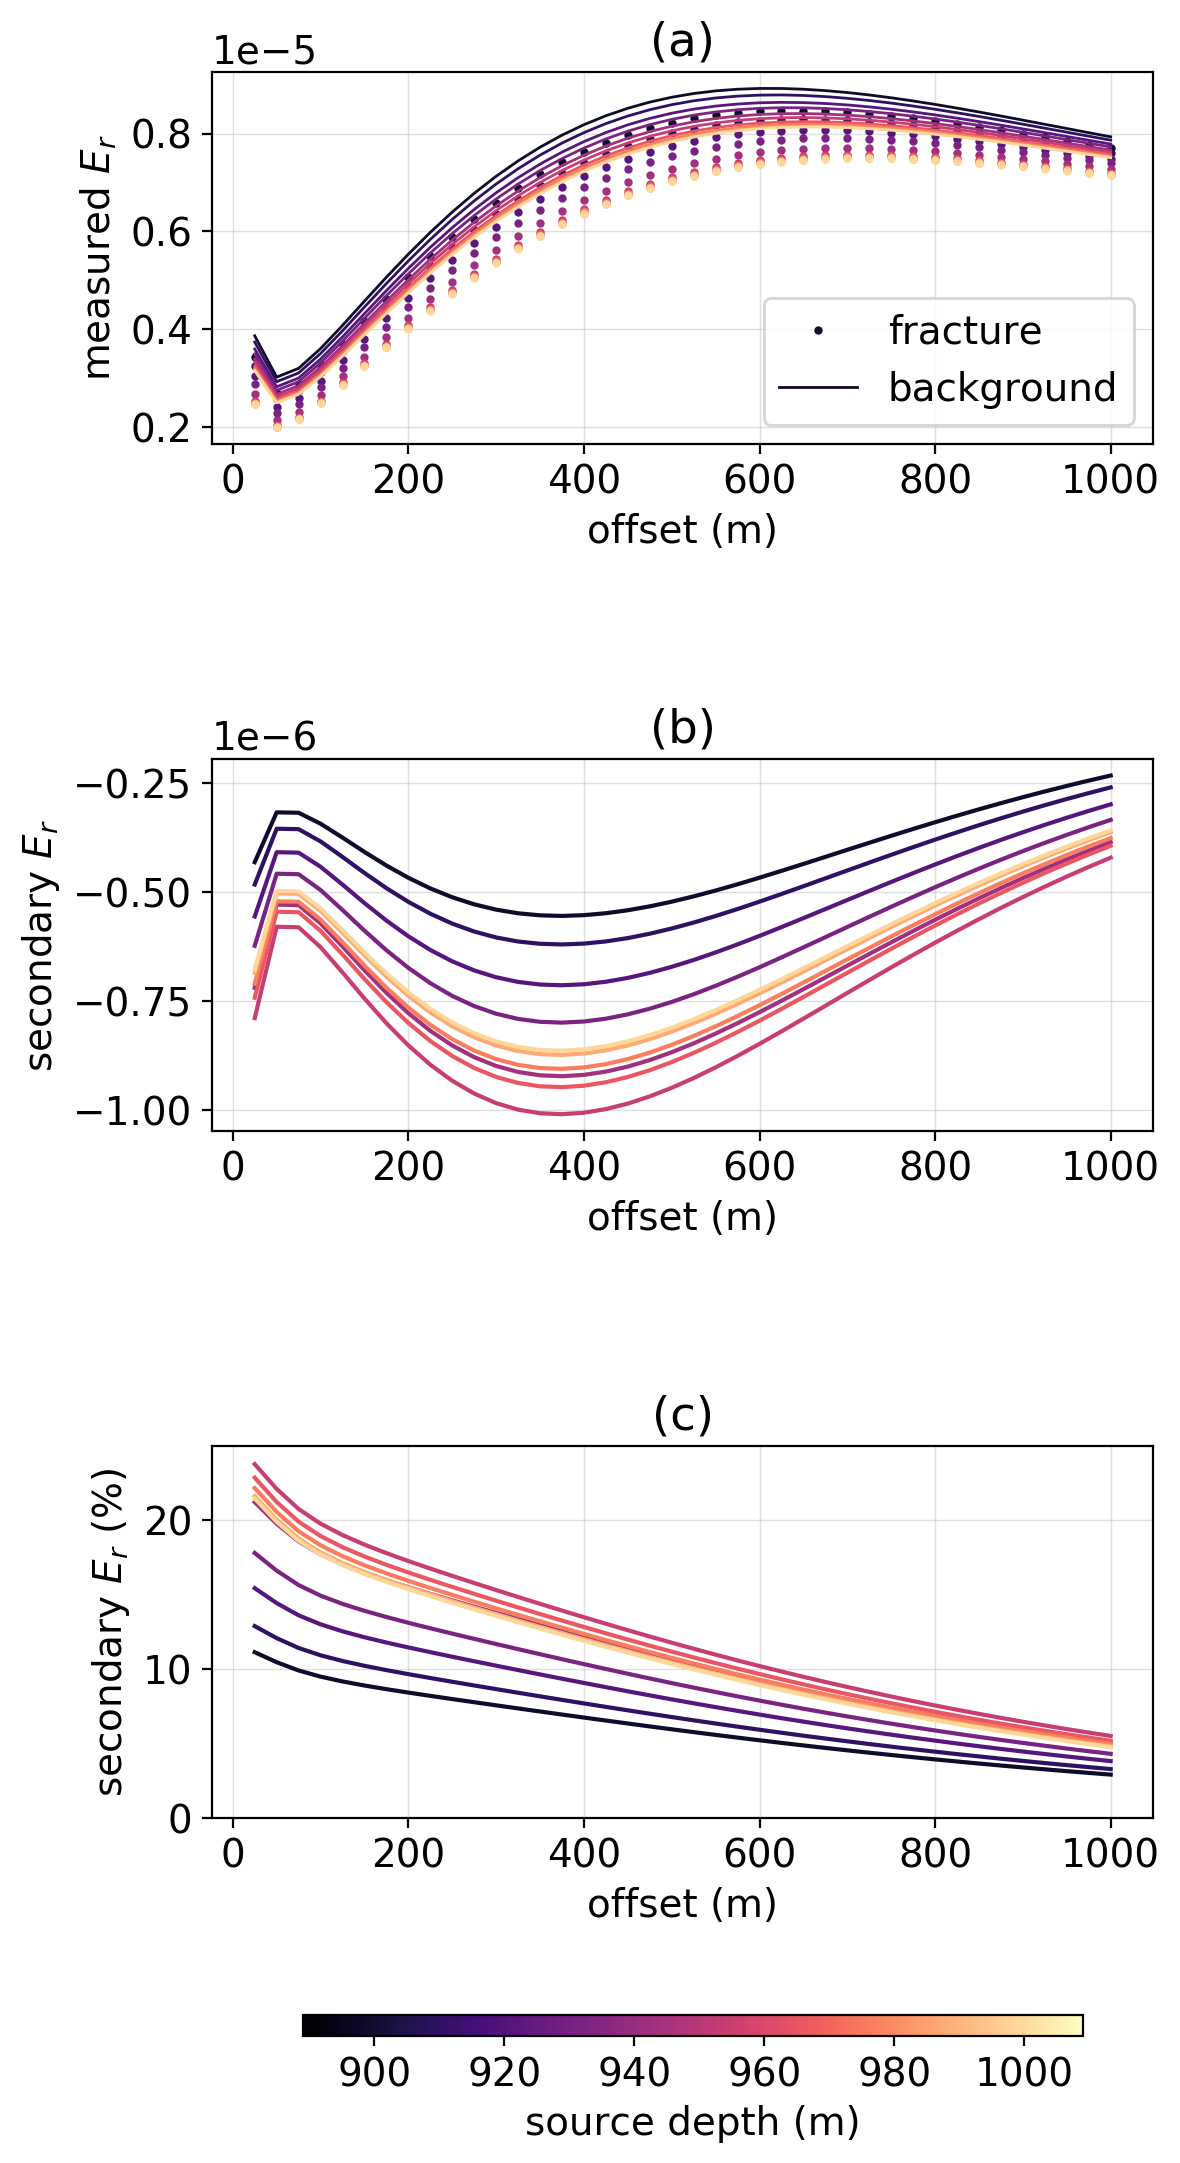

In [36]:
ncols = 2 if include_obswell else 1
fig, ax = plt.subplots(3, ncols, figsize=(ncols*6, 3*3.5), dpi=200)
plot_data(
    data_dict["fracture"]["data_x"], data_dict["background"]["data_x"],
    True, label_obs="fracture", label_pred="background", plot_style="plot",
    fig=fig, ax=ax[:, 0] if include_obswell else ax, reverse_difference=True
)

ax[2].set_ylim([0, 25])

if include_obswell:
    plot_data(
        data_dict["fracture"]["data_z"], data_dict["background"]["data_z"],
        True, label_obs="fracture", label_pred="background", plot_style="plot",
        fig=fig, x=ax[:, 1], component="z"
    )
    
fig.savefig('../figures/dc_casing_initial_data', bbox_inches="tight")

In [37]:
def plot_inversion(dpred, mapping, mrec, xlim=95*np.r_[-1, 1], ylim=[-1100, -800], clim=None, plot_well=True):
    
    fig = plt.figure(figsize=(13, 8), dpi=200)
    ax0 = plt.subplot2grid((3, 7), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 7), (1, 0), colspan=3)
    ax2 = plt.subplot2grid((3, 7), (2, 0), colspan=3)
    ax3 = plt.subplot2grid((3, 7), (0, 3), rowspan=3, colspan=4)
    # ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

    # plot data
    plot_data(
        data_dict["fracture"]["data_x"], wrangle_data(dpred, "x"), ax=[ax0, ax1, ax2], plot_percentage=True)

    ax1.set_ylabel("difference $E_r$")
    ax2.set_ylabel("difference $E_r$ (%)")

    # plot model
    
    if clim is None:
        clim = [np.min([sigma_back, np.exp(mrec).min()]) , np.exp(mrec).max()]
    out_rec = phys_props_dict["fracture"].plot_prop(
        mapping * mrec, ax=ax3, pcolorOpts={'norm':LogNorm()}, 
        clim=clim
    )
    ax3.set_title("(d)")
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    ax3.set_aspect(1)
    ax3.set_ylabel("z(m)")
    ax3.set_xlabel("x(m)")
    out_rec[-1].set_label("conductivity (S/m)")

    ax3.plot(
        model.target_radius[1]*np.r_[-1, -1, 1, 1, -1], 
        model.target_z[[0, 1, 1, 0, 0]],
        color='w'
    )
    
    if plot_well is True:
        ax3.plot(
            np.r_[0., 0], model.casing_z, color=[0.7, 0.7, 0.7]
        )

    plt.tight_layout()

    return fig, [ax0, ax1, ax2, ax3], out_rec

## Set up an inversion

In [38]:
STD = 0.01
EPS = 1e-9
CHIFACT = 0.05

In [39]:
# Construct mapping
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
mapping = ExpMap * InjectInactiveCells

In [40]:
def get_prob_survey(mapping):
    prob_inv = DC.Problem3D_CC(
        mesh, sigmaMap=mapping, bc_type='Dirichlet', Solver=Pardiso
    )
    survey_inv = DC.Survey(src_list)
    prob_inv.pair(survey_inv)
    
#     d = discretize.utils.mkvc(np.vstack(data_dict["fracture"]))
    survey_inv.dobs = data_dict["fracture"]["data"]
    survey_inv.std = STD
    survey_inv.eps = EPS
    
    return prob_inv, survey_inv

In [41]:
prob_inv, survey_inv = get_prob_survey(mapping)

Homogeneous Dirichlet is the natural BC for this CC discretization.


## Plot the sensitivity

In [42]:
def plot_sensitivity(Jlist, xlim=100*np.r_[-1, 1], ylim=np.r_[-1200, 0], clim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, len(Jlist), figsize=(6*len(Jlist), 6))
    
    Jlist = [J.sum(0) for J in Jlist]
    if clim is None:
        Jmax = np.abs(np.hstack(Jlist)).max()
        clim = Jmax*np.r_[-1, 1]
    
    for a, J in zip(ax, Jlist): 
        cbar = plt.colorbar(mesh.plotImage(
            Maps.InjectActiveCells(mesh, ~ind_inactive, 0) * J, ax=a,
            mirror=True, clim=clim
        )[0], ax=a)
        a.set_xlim(xlim)
        a.set_ylim(ylim)
    
    plt.tight_layout()

    return (ax, cbar)
    

In [43]:
prob_inv.model = np.ones((~ind_inactive).sum())*sigma_back
J_l2_m0 = prob_inv.getJ(np.ones((~ind_inactive).sum())*sigma_back)
                        
prob_inv.model = np.log(model.sigma(mesh)[~ind_inactive])
J_l2_target = prob_inv.getJ(np.log(model.sigma(mesh)[~ind_inactive]))

(array([<matplotlib.axes._subplots.AxesSubplot object at 0xd1ab51748>,
       dtype=object), <matplotlib.colorbar.Colorbar at 0xd1a930c88>)

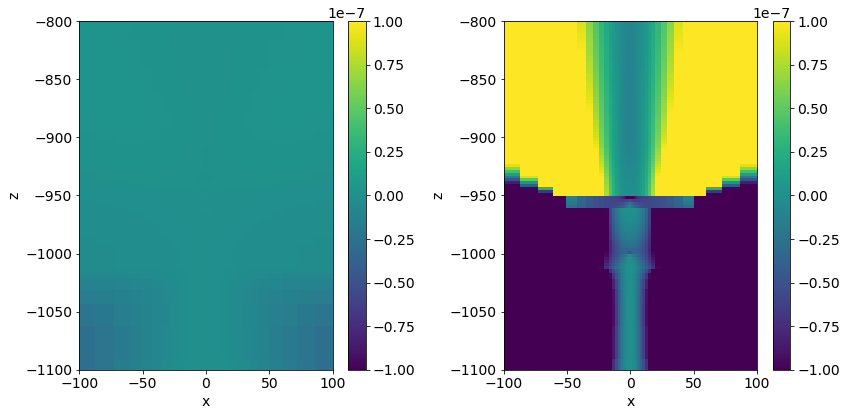

In [44]:
plot_sensitivity(
    [J_l2_m0, J_l2_target], clim=1e-7*np.r_[-1, 1], 
    xlim = 100*np.r_[-1., 1.],
    ylim = np.r_[-1100, -800]
)

## Run the inversion

In [45]:
regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg = Regularization.Tikhonov(regmesh, alpha_s=1e-3, alpha_x=1, indActive=~ind_inactive)
dmis = DataMisfit.l2_DataMisfit(survey_inv)
opt = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
# opt = Optimization.ProjectedGNCG(maxIterCG=10, maxIter=10, remember='xc', lower=np.log(sigma_back), stepOffBoundsFact=1e-2)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(directory="smooth_inversion"),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv = Inversion.BaseInversion(invProb, directiveList=directives)

In [46]:
directives[-2].directory

'smooth_inversion'

In [47]:
m0 = np.log(sigma_back * np.ones(mapping.nP)) + 1e-10

In [48]:
%%time
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: 'smooth_inversion/###-InversionModel-2018-08-17-14-53.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.61e-01  1.28e+03  0.00e+00  1.28e+03    5.97e+02      0              
   1  6.61e-01  3.83e+01  1.04e+00  3.90e+01    5.08e+01      0              
   2  6.61e-01  1.12e+01  2.06e+00  1.26e+01    6.20e+00      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.2785e+02
1 : |xc-x_last| = 2.4808e+01 <= tolX*(1+|x0|) = 9.1809e+01
0 : |proj(

saving ../figures/dc_smooth_inversion_5e-02.png


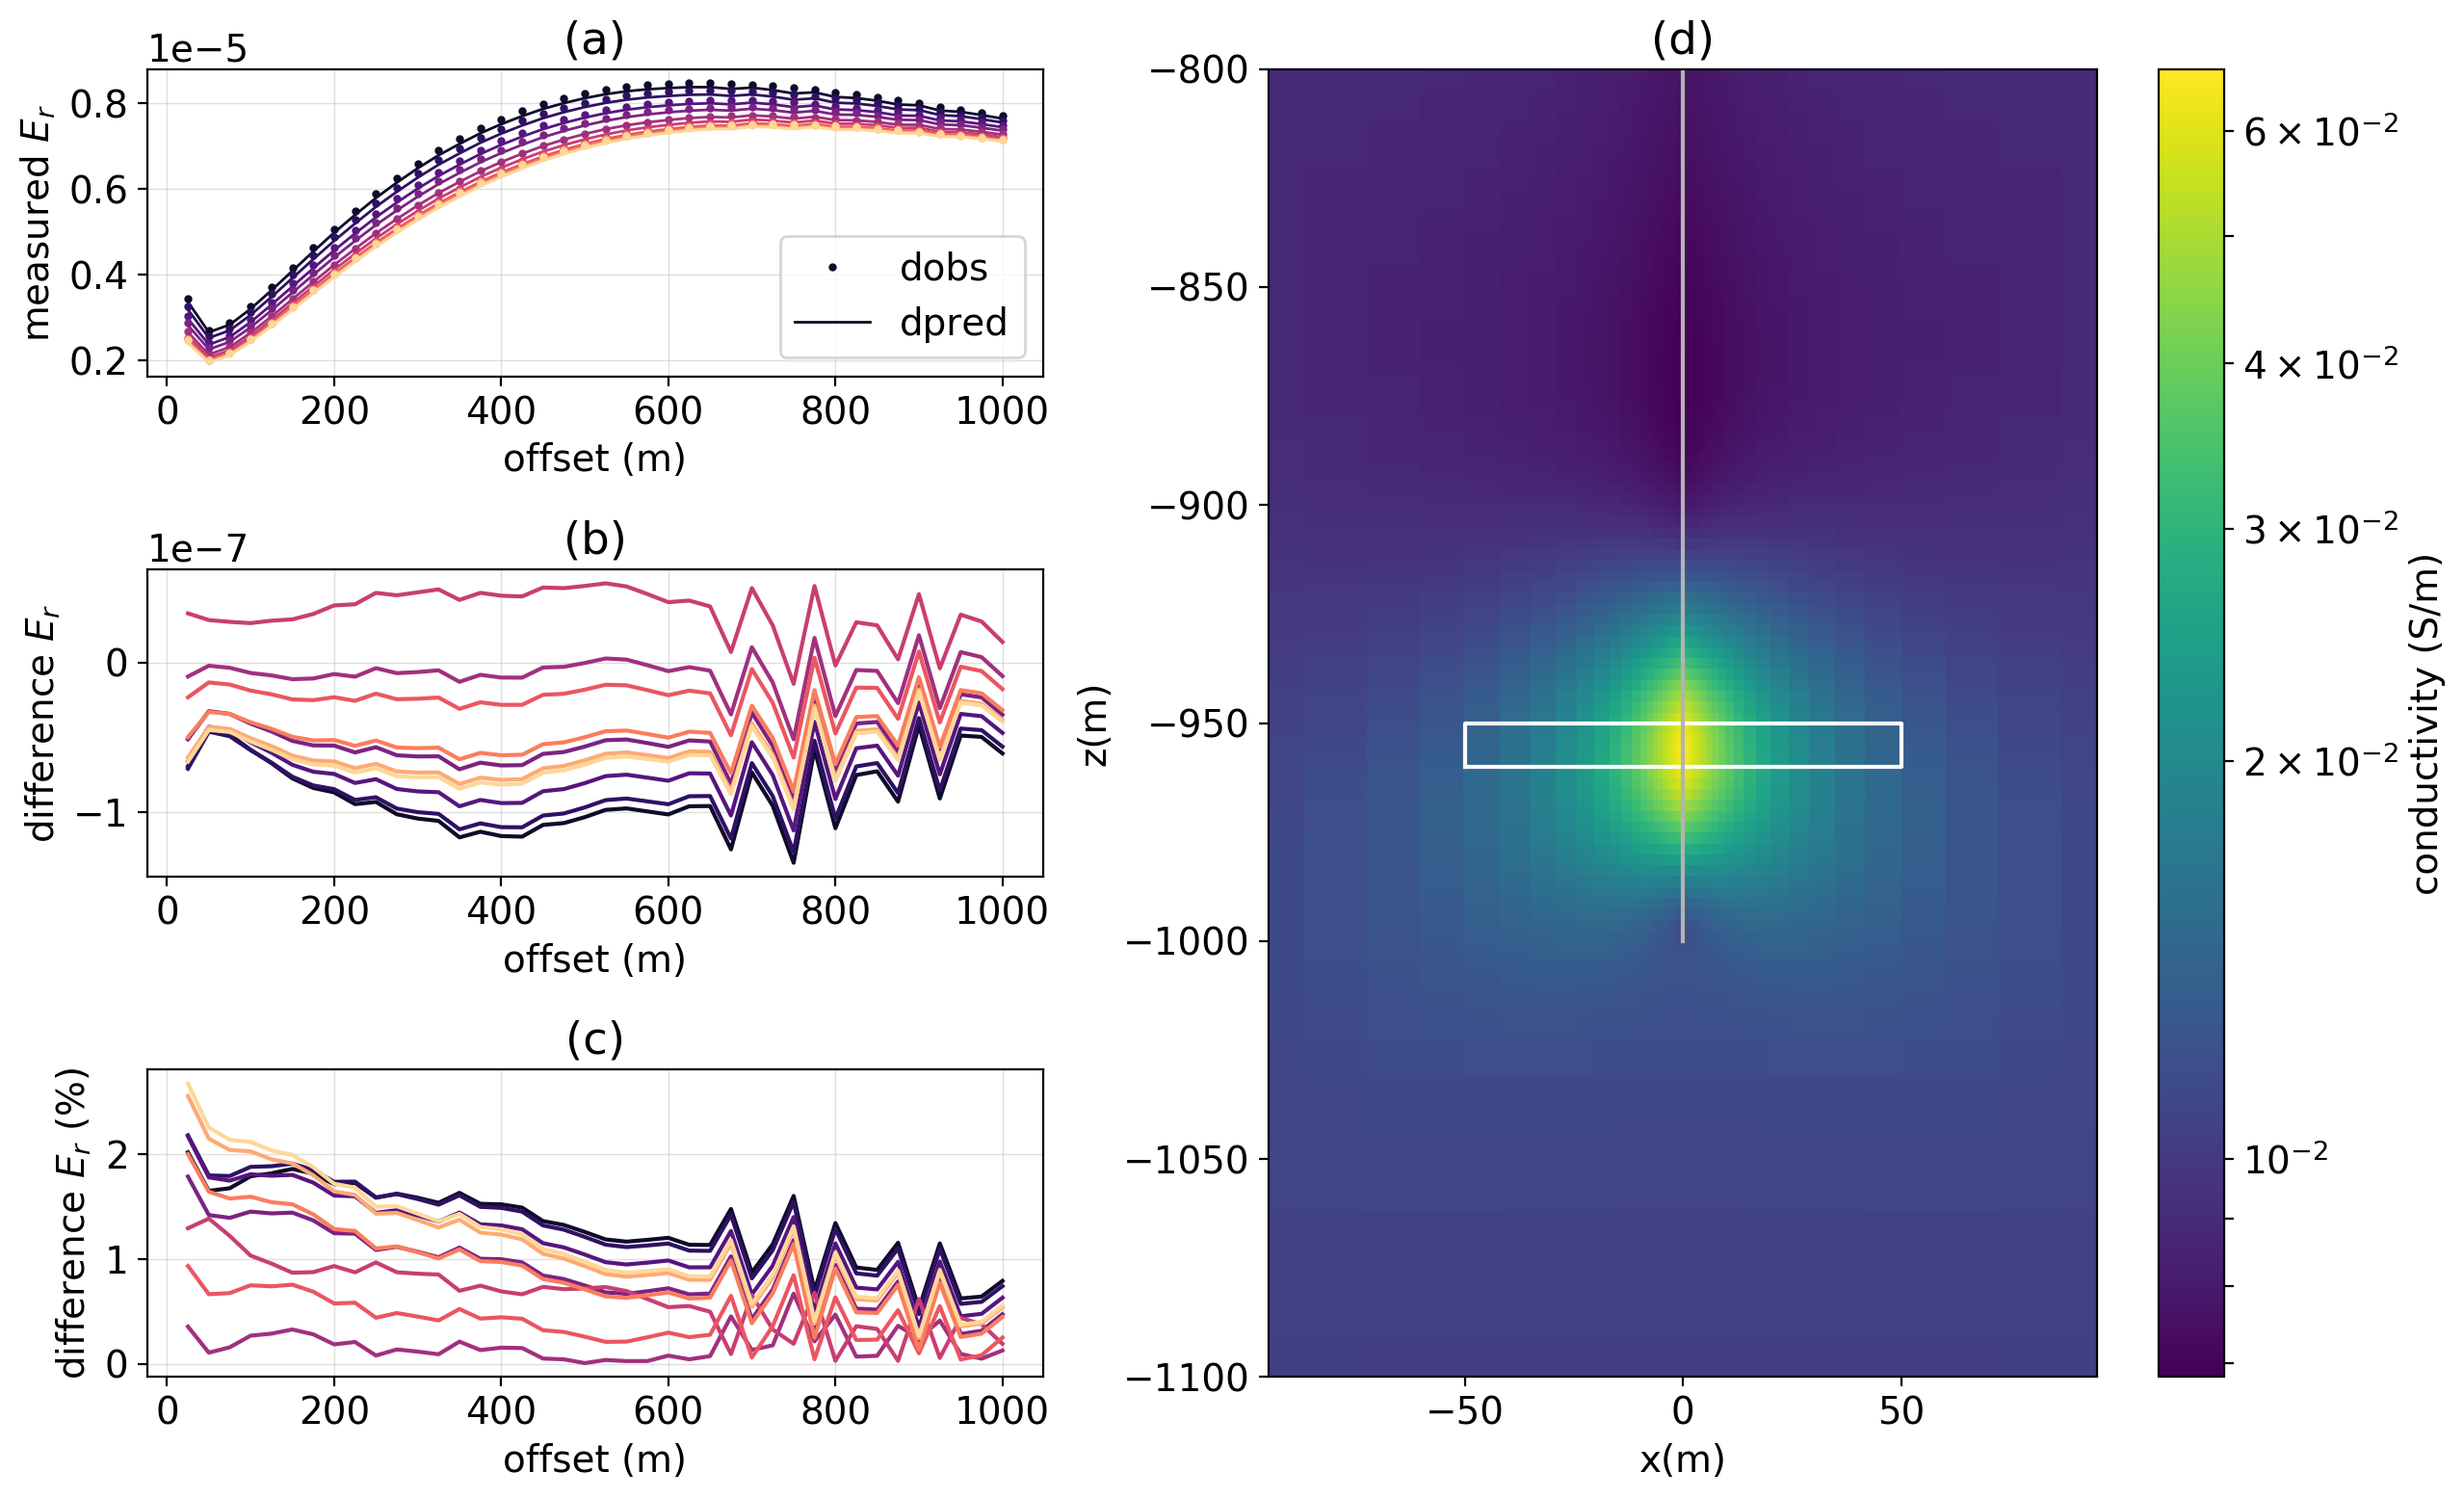

In [49]:
fig, ax, out = plot_inversion(invProb.dpred, mapping, mrec)

if reg.alpha_x == 1:
    if isinstance(opt, Optimization.ProjectedGNCG):
        name = '../figures/dc_smooth_inversion_{:1.0e}_bounded'.format(CHIFACT)
        
    else: 
        name = '../figures/dc_smooth_inversion_{:1.0e}'.format(CHIFACT)
else:
    if isinstance(opt, Optimization.ProjectedGNCG):
        name = '../figures/dc_smooth_inversion_{:1.0e}_alpha_{:1.0f}_bounded'.format(CHIFACT, reg.alpha_x)
    else: 
        name = '../figures/dc_smooth_inversion_{:1.0e}_alpha_{:1.0f}'.format(CHIFACT, reg.alpha_x)

print("saving {}.png".format(name))
fig.savefig(name, dpi=200)

## Parametric inversion

- block in a halfspace
- ellipsoid? 

In [91]:
# mapping_parametric
ExpMap = Maps.ExpMap(mesh)
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=5e-2, p=4)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0[2] = False
InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
    valInactive=0.
)

# indActiveX0Z0 = np.ones(ParametricBlock.nP, dtype=bool)
# indActiveX0Z0[[2, 4]] = [False]*2
# InjectX0Z0 = InjectX0 = Maps.InjectActiveCells(
#     discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0Z0,
#     valInactive=np.r_[0., np.mean(model.target_z)]
# )

# mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0Z0
mapping_parametric = ExpMap * InjectInactiveCells * ParametricBlock * InjectX0

In [92]:
m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 10., model.target_z.mean(), 5.]
# m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 10., model.target_z.mean(), 10.]
# m0_parametric = np.r_[np.log(sigma_back), np.log(3e-2), 10., 10.]

In [93]:
mapping_parametric.test(m0_parametric)

Testing ComboMap[ComboMap[ComboMap[ExpMap(43316,43316) * InjectActiveCells(43316,39658)](43316,39658) * ParametricBlock(39658,6)](43316,6) * InjectActiveCells(6,5)](43316,5)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.091e-01     1.041e-02      nan
 1   1.00e-02    1.998e-02     1.008e-04      2.014
 2   1.00e-03    1.989e-03     1.005e-06      2.001
 3   1.00e-04    1.988e-04     1.005e-08      2.000
========================= PASS! =========================
Awesome, Lindseyjh, just awesome.



True

Text(0.5,1,'starting')

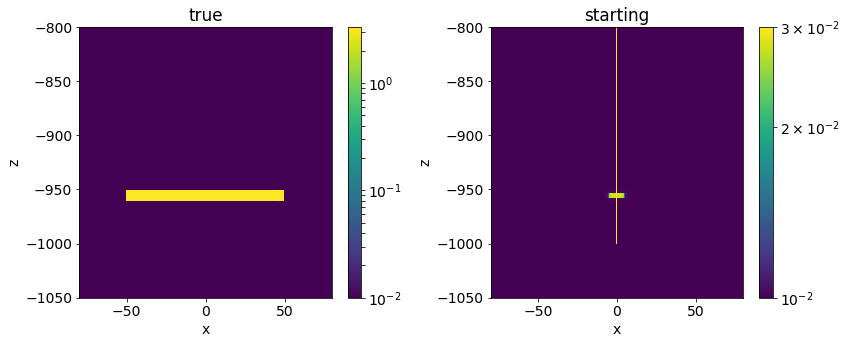

In [94]:
out = plot_models(m0_parametric, mapping_parametric, clim=[np.min(np.r_[sigma_back, np.exp(m0_parametric[:2].min())]), np.exp(m0_parametric[:2].max())])
out[0][1].set_title("starting")

In [95]:
prob_parametric, survey_parametric = get_prob_survey(mapping_parametric)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [ ]:
# regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([mapping_parametric.nP]))
dmis_parametric = DataMisfit.l2_DataMisfit(survey_parametric)
opt_parametric = Optimization.InexactGaussNewton(maxIterCG=5, maxIter=30, remember='xc')
invProb_parametric = InvProblem.BaseInvProblem(dmis_parametric, reg_parametric, opt_parametric, beta=0)
directives = [
#     Directives.SaveOutputEveryIteration(),
    Directives.SaveModelEveryIteration(directory="parametric_z0_correct_thin"),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_parametric = Inversion.BaseInversion(invProb_parametric, directiveList=directives)

In [ ]:
%%time
mrec_parametric = inv_parametric.run(m0_parametric)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: 'parametric_z0_correct_thin/###-InversionModel-2018-08-17-16-16.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.17e+03  4.63e+06  1.17e+03    2.62e+04      0              
   1  0.00e+00  1.05e+02  4.63e+06  1.05e+02    1.35e+03      0              
   2  0.00e+00  1.01e+02  4.63e+06  1.01e+02    1.53e+01      0   Skip BFGS  
   3  0.00e+00  5.38e+01  4.63e+06  5.38e+01    1.11e+02      1   Skip BFGS  
   4  0.00e+00  5.38e+01  4.63e+06  5.38e+01    2.80e+00      0              
   5  0.00e+00  3.

In [ ]:
def print_parametric(m): 
    model_info = (
        "sigma back   : {:1.2e} S/m\n"
        "sigma target : {:1.2e} S/m\n"
        "target radius: {:1.2f} m\n"
        "target top   : {:1.2f} m\n"
        "target_bottom: {:1.2f} m\n"
    )
    if len(m) == 5: 
        print(
            model_info.format(
                np.exp(m[0]), np.exp(m[1]), 
                m[2]/2,
                m[3] + m[4]/2, 
                m[3] - m[4]/2
            )
        )
    elif len(m) == 4:
        print(
           model_info.format(
                np.exp(m[0]), np.exp(m[1]), 
                m[2]/2,
                InjectX0Z0.valInactive[4] + m[3]/2, 
                InjectX0Z0.valInactive[4] - m[3]/2
            )
        )

In [ ]:
print_parametric(m0_parametric)

In [ ]:
print_parametric(mrec_parametric)
# np.exp(mrec_parametric[[0, 1]])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 5))
xlim = 80*np.r_[-1, 1]
ylim = [-1050, -900]
clim_start = [np.min(np.r_[sigma_back, np.exp(m0_parametric[:2].min())]), np.exp(m0_parametric[:2].max())]
clim_rec = [np.min(np.r_[sigma_back, np.exp(mrec_parametric[:2].min())]), np.exp(mrec_parametric[:2].max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
)
out_initial = phys_props_dict[key].plot_prop(
    mapping_parametric * m0_parametric, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim_start
)
out_rec = phys_props_dict[key].plot_prop(
    mapping_parametric * mrec_parametric, ax=ax[2], pcolorOpts={'norm':LogNorm()}, clim=clim_rec
)

for a, title in zip(ax, ["true", "starting", "recovered"]):
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(title)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [ ]:
def block_plotting_coordinates(x, dx, z, dz):
    return (
        np.r_[x-dx/2, x-dx/2, x+dx/2, x+dx/2, x-dx/2], 
        np.r_[z-dz/2, z+dz/2, z+dz/2, z-dz/2, z-dz/2]
    )

In [ ]:
parametric_models = [
    np.load(directives[-2].directory + '/' + f) for f in
    sorted(os.listdir(directives[-2].directory))
]

In [ ]:
def plot_parametric(it=0):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    m = parametric_models[it]
    clim_rec = [np.min(np.r_[sigma_back, np.exp(m[:2].min())]), np.exp(m[:2].max())]

    out_rec = phys_props_dict[key].plot_prop(
        mapping_parametric * m, 
        pcolorOpts={'norm':LogNorm()}, clim=clim_rec, ax=ax
    )
    block_true = block_plotting_coordinates(
        0, model.target_radius[1]*2, model.target_z.mean(), model.target_z[1] - model.target_z[0]
    )
    block = block_plotting_coordinates(
        0, m0_parametric[2], m0_parametric[3] if len (m0_parametric) == 5 else InjectX0Z0.valInactive[4], 
        m0_parametric[4] if len(m0_parametric) == 5  else m0_parametric[3]
    )
    ax.plot(block_true[0], block_true[1], color="w", ls="-")
    ax.plot(block[0], block[1], color="w", ls="--")
    ax.set_xlim(80*np.r_[-1, 1])
    ax.set_ylim([-1100, -800])
    
    plt.show()

In [ ]:
ipywidgets.interact(
    plot_parametric, 
    it = ipywidgets.IntSlider(min=0, max=len(parametric_models)-1, val=0)
)

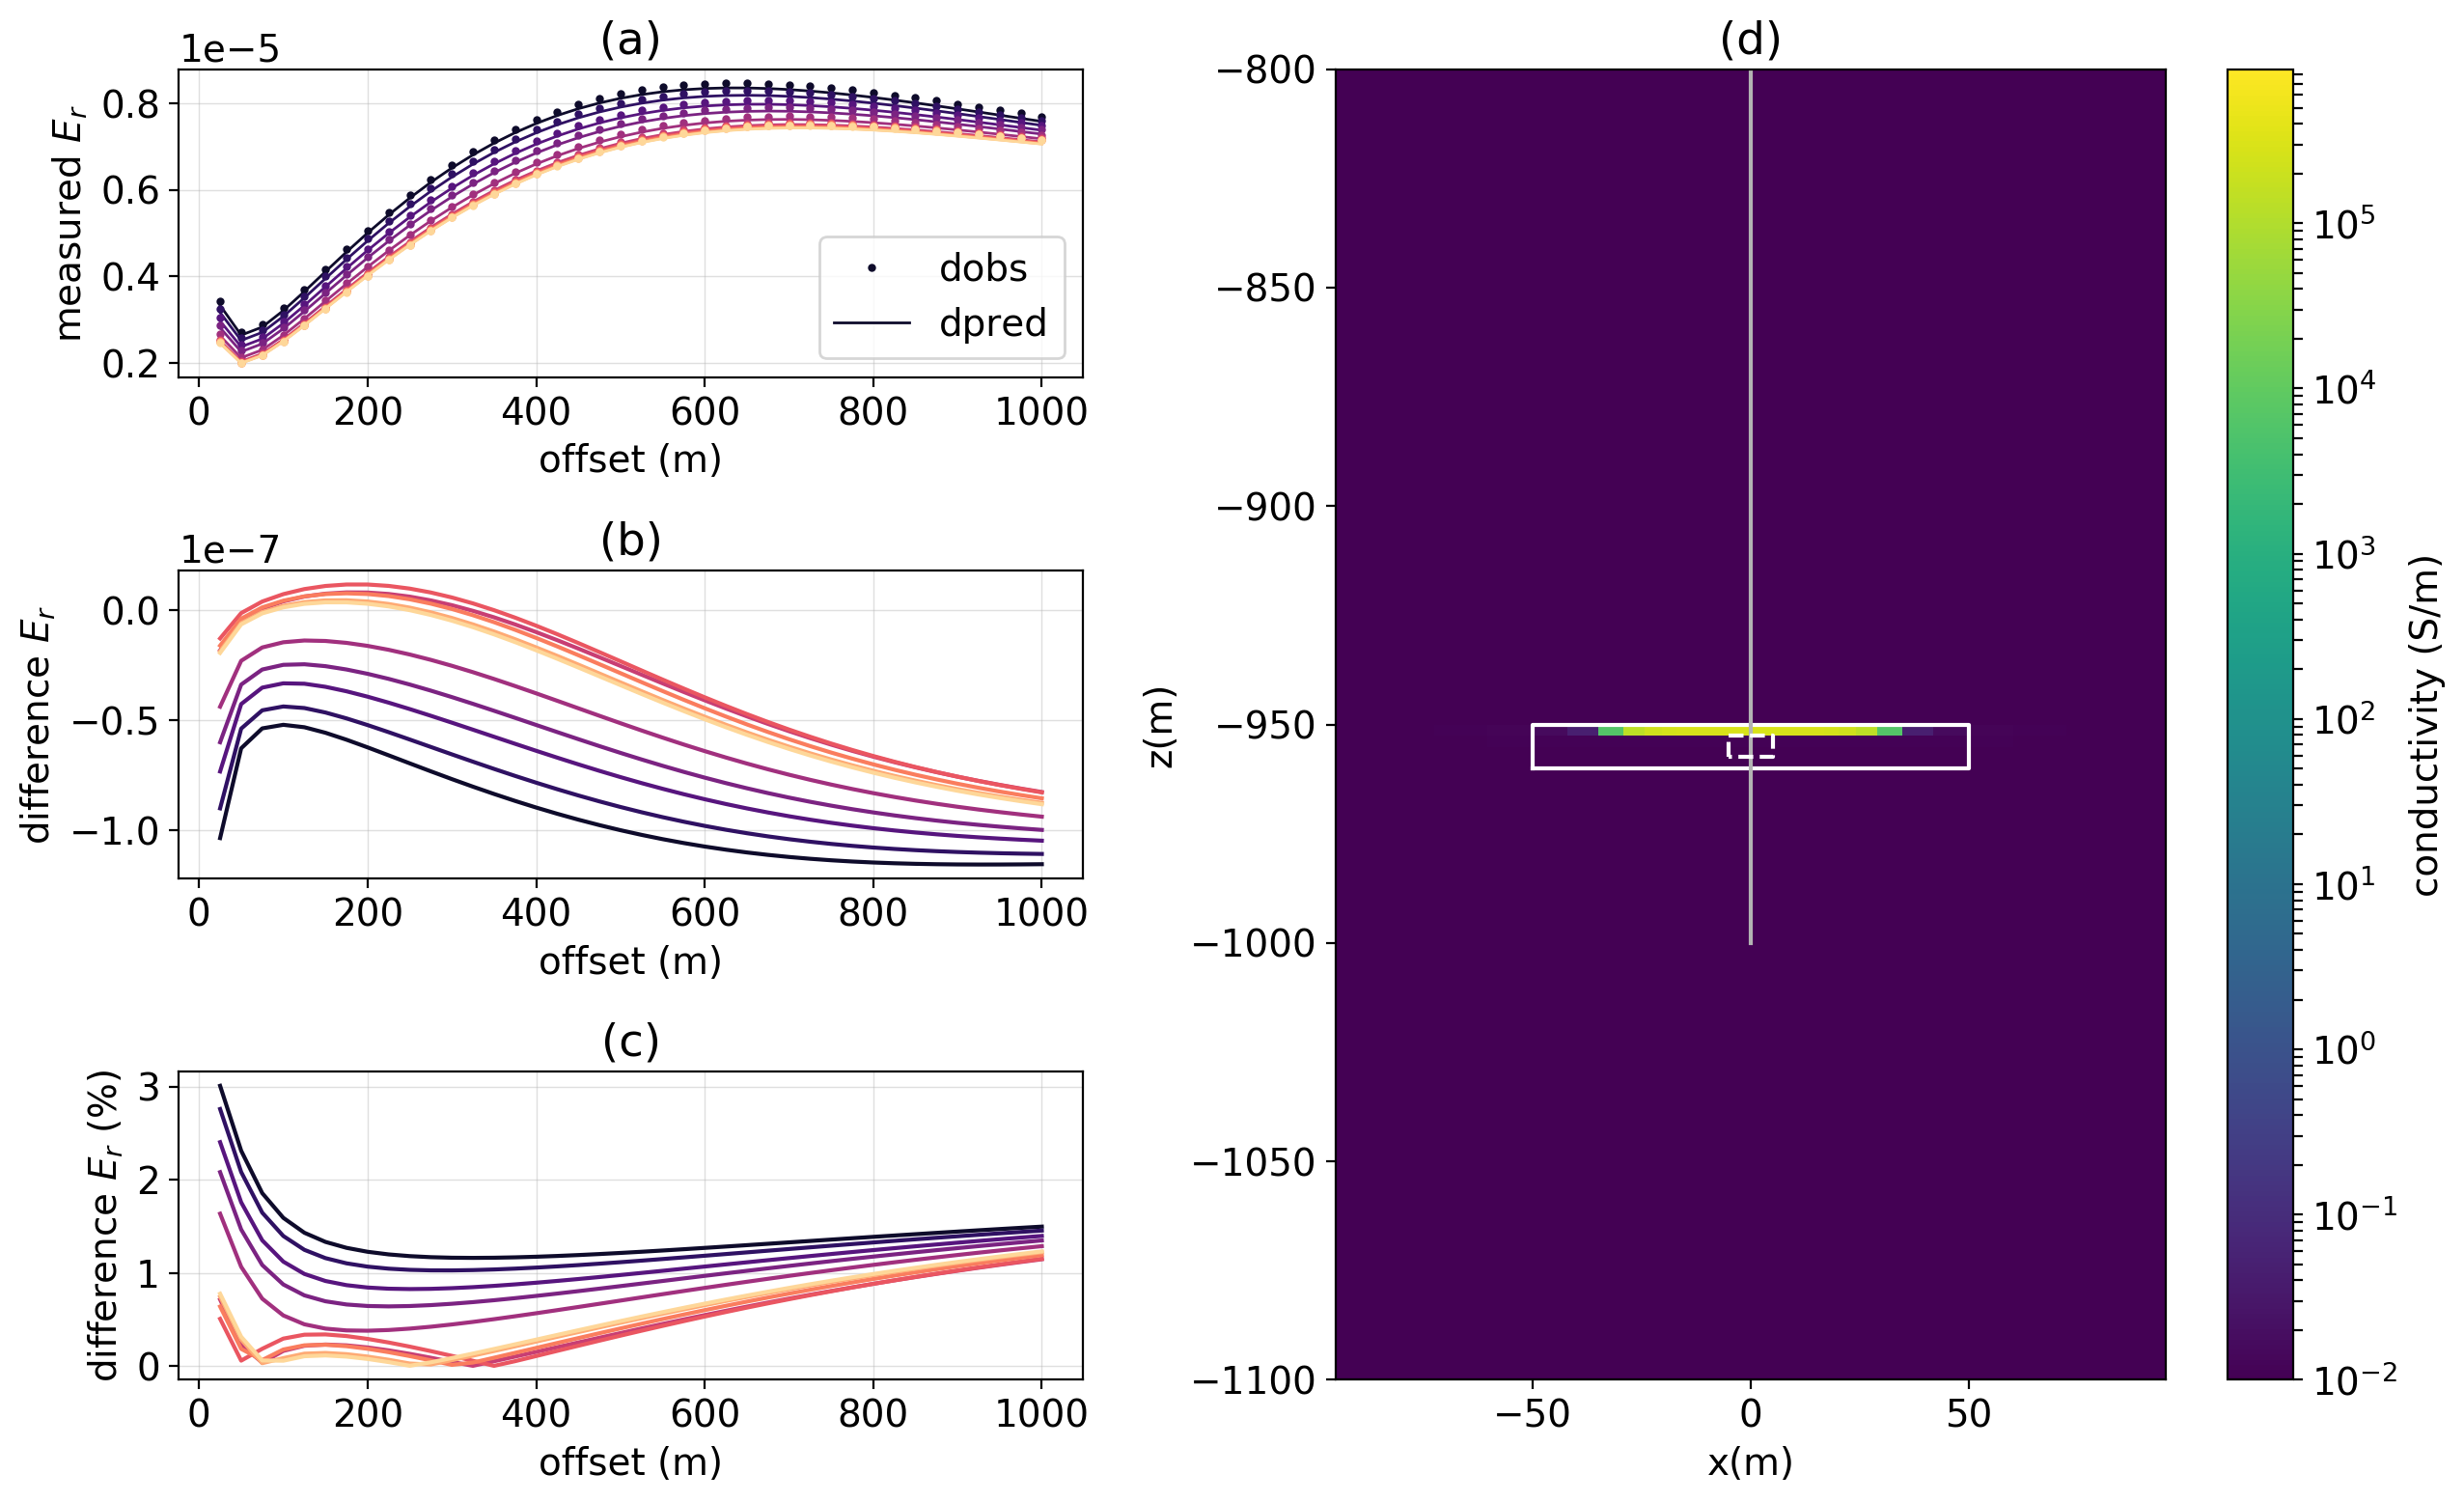

In [90]:
fig, ax, out = plot_inversion(
    invProb_parametric.dpred, mapping_parametric, mrec_parametric, 
    clim=[
        np.min(np.r_[sigma_back, np.exp(mrec_parametric[:2]).min()]),
        np.max(np.exp(mrec_parametric[:2]))
    ]
)
block = block_plotting_coordinates(
    0, m0_parametric[2], m0_parametric[3] if len (m0_parametric) == 5 else InjectX0Z0.valInactive[4], 
    m0_parametric[4] if len(m0_parametric) == 5  else m0_parametric[3]
) 
ax[3].plot(block[0], block[1], color="w", ls="--")

# fig.savefig("../figures/parametric_correct_z0_dz", dpi=200)
# fig.savefig("../figures/parametric_fixed_z0", dpi=200)
# fig.savefig("../figures/parametric_based_on_voxel1", dpi=200)
fig.savefig("../figures/parametric_boased_on_voxel2", dpi=200)

## SCEMT mapping

In [329]:
scemt_mapping = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=(~ind_inactive).sum()
)

In [330]:
phi_true = scemt_mapping.inverse(model.sigma(mesh)[~ind_inactive])

### L2 Inversion with SCEMT mapping

In [331]:
mapping_scemt = Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive) * scemt_mapping

In [332]:
prob_scemt, survey_scemt = get_prob_survey(mapping_scemt)

Homogeneous Dirichlet is the natural BC for this CC discretization.


In [333]:
m0_scemt = 1e-10 + np.zeros(mapping_scemt.nP)

In [337]:
mapping_scemt.test(m0_scemt, dx=0.01*np.random.rand(mapping_scemt.nP))

Testing ComboMap[InjectActiveCells(43316,39658) * SelfConsistentEffectiveMedium(39658,39658)](43316,39658)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.188e+02     9.107e+01      nan
 1   1.00e-02    6.619e+00     3.900e+00      1.368
 2   1.00e-03    3.055e-01     2.914e-02      2.126
 3   1.00e-04    2.799e-02     2.697e-04      2.034
========================= PASS! =========================
And then everyone was happy.



True

In [402]:
reg_scemt = Regularization.Tikhonov(
    regmesh, alpha_s=1e-3, alpha_x=100, indActive=~ind_inactive, mref=np.zeros(mapping_scemt.nP)
)
dmis_scemt = DataMisfit.l2_DataMisfit(survey_scemt)
opt_scemt = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=10, remember='xc', lower=0., upper=1., stepOffBoundsFact=1e-4
)
invProb_scemt = InvProblem.BaseInvProblem(dmis_scemt, reg_scemt, opt_scemt)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact= CHIFACT)
]
inv_scemt = Inversion.BaseInversion(invProb_scemt, directiveList=directives)

In [403]:
mrec_scemt = inv_scemt.run(m0_scemt)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.28e+06  1.28e+03  1.17e-16  1.28e+03    1.80e+02      0              
   1  4.28e+06  4.34e+01  4.49e-09  4.34e+01    1.77e+02      0              
   2  4.28e+06  3.46e+01  1.50e-08  3.47e+01    9.00e+01      0   Skip BFGS  
   3  5.35e+05  1.36e+01  1.37e-08  1.36e+01    8.57e+01      0              
   4  5.35e+05  1.13e+01  2.45e-08  1.14e+01    9.16e+01      2   Skip BFGS  
   5  5.35e+05  1.08e+01  1.81e-07  1.09e+01    8.94e+01      1              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.2784e+02
1 : |

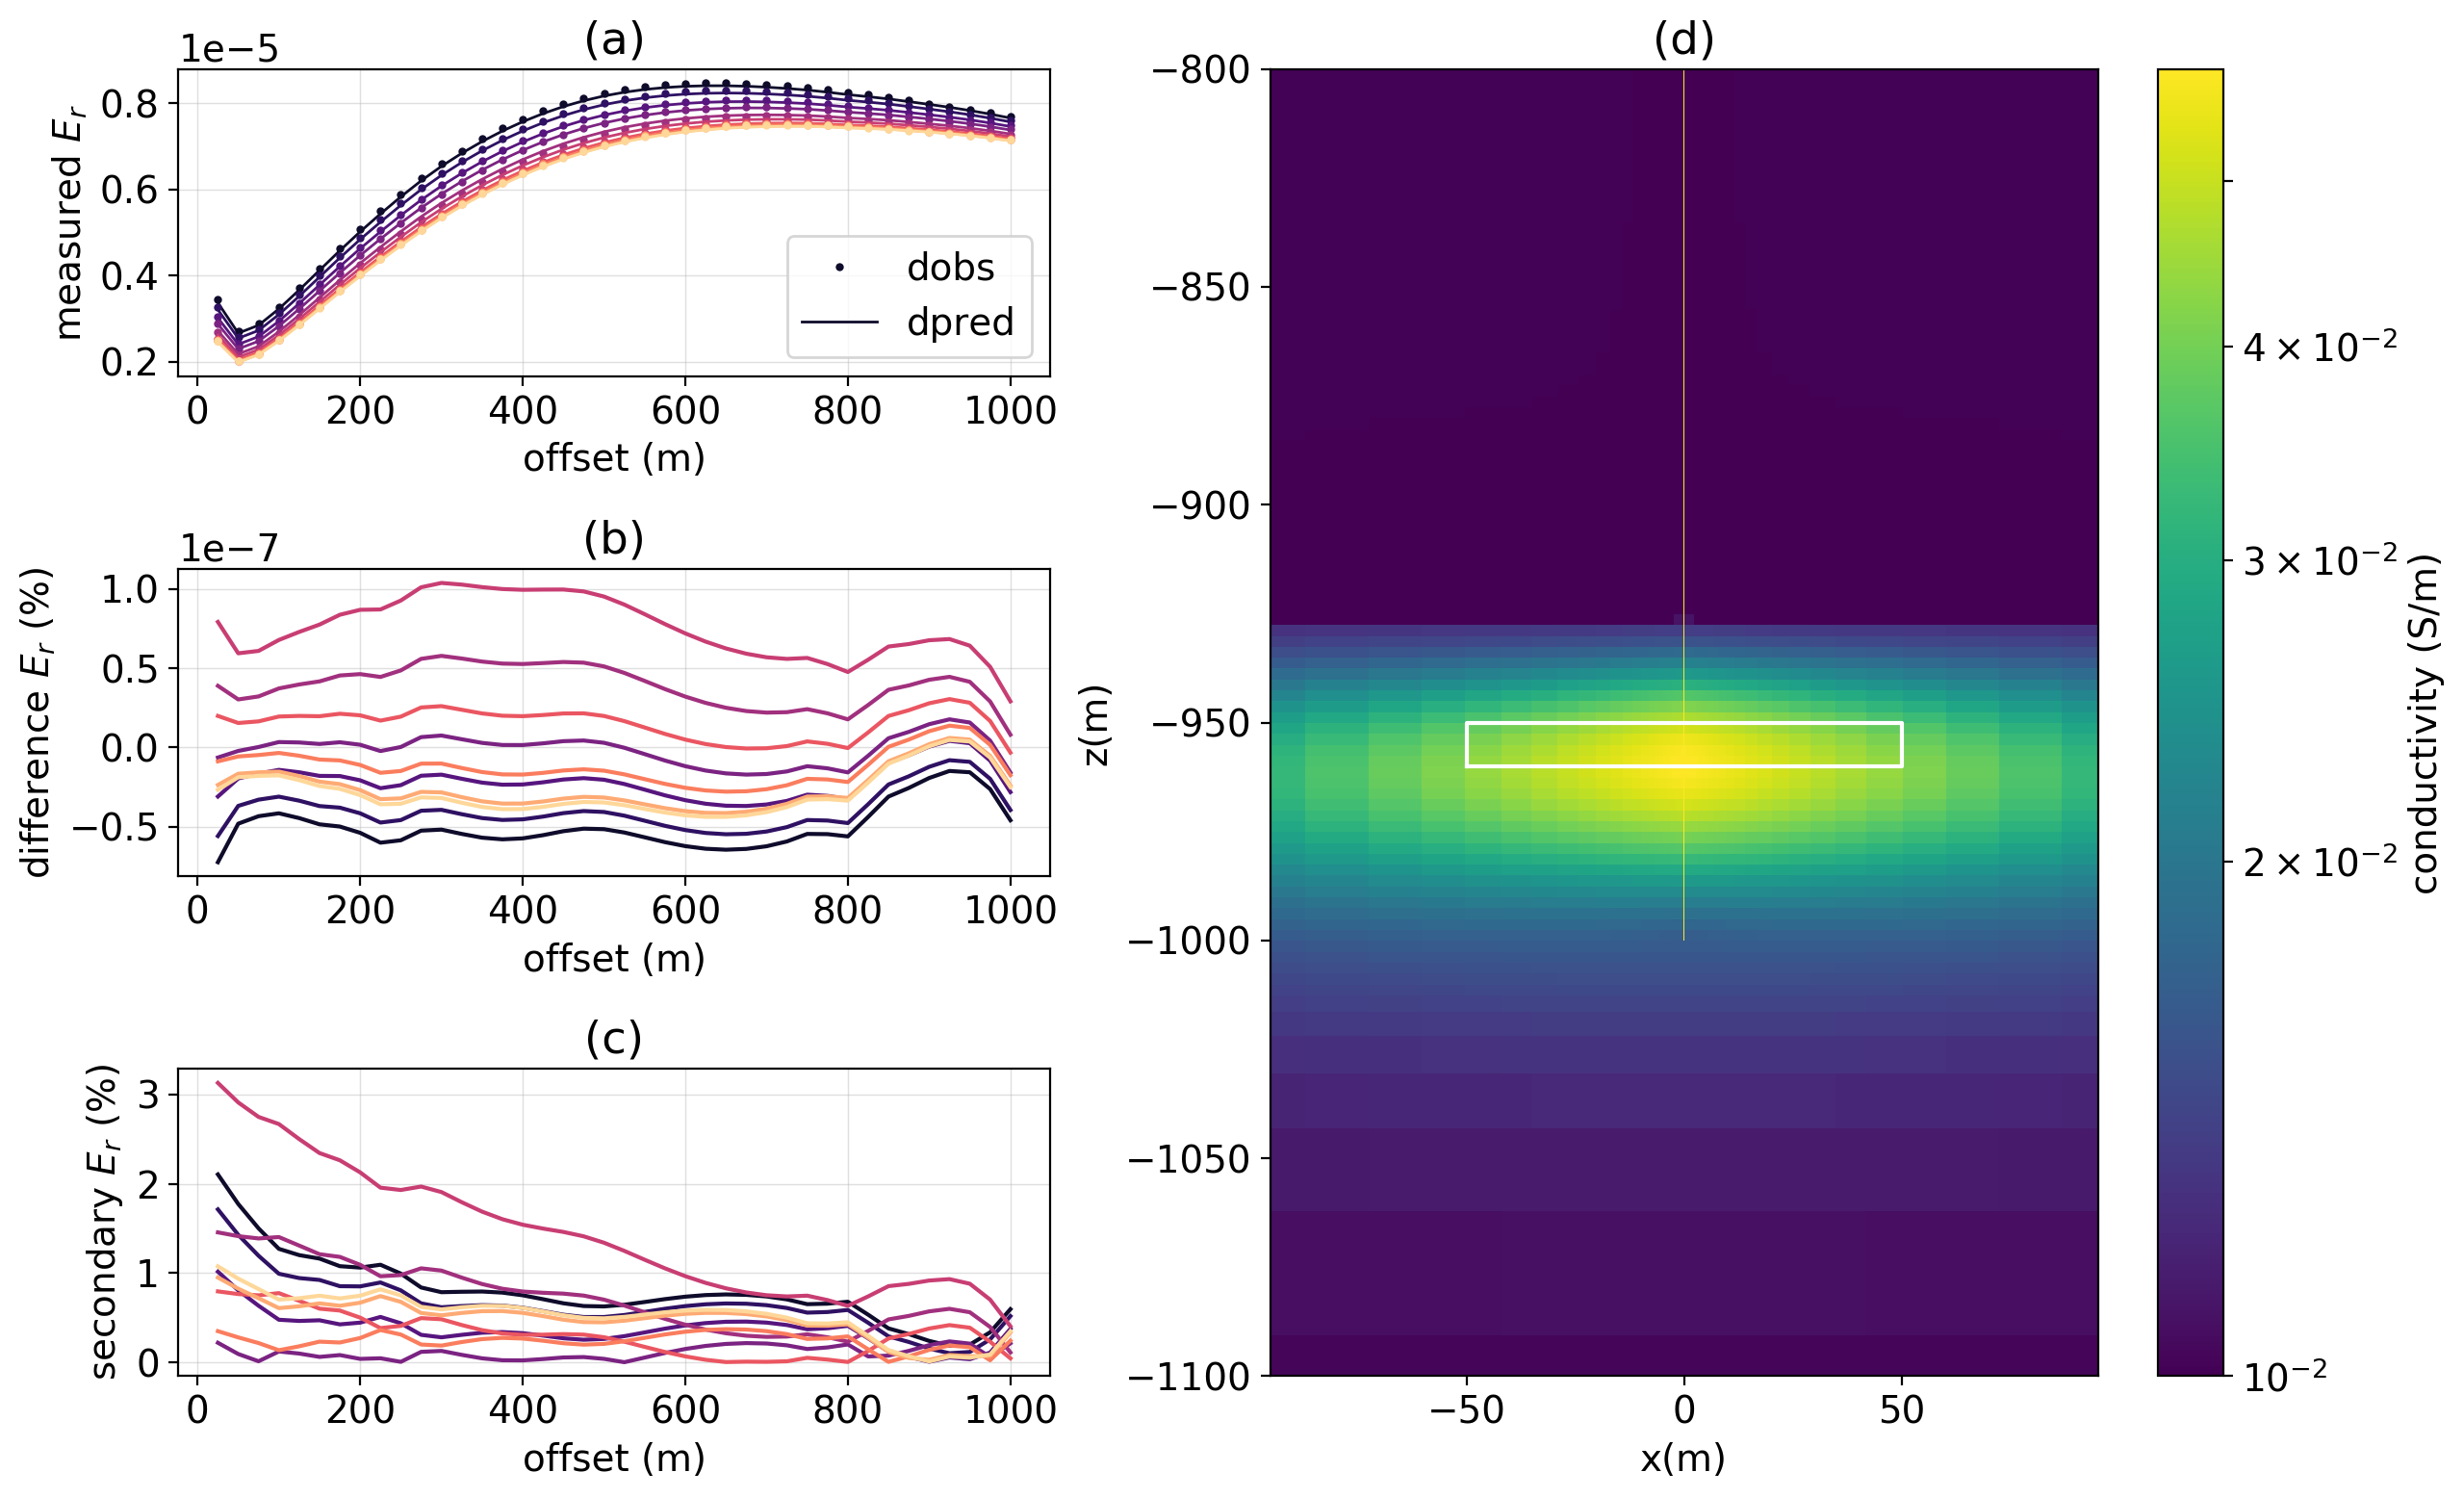

In [404]:
fig, ax, out = plot_inversion(invProb_scemt.dpred,  mapping_scemt, mrec_scemt, clim=np.r_[
        np.min(np.r_[sigma_back, (scemt_mapping * mrec_scemt).min()]), 
        (scemt_mapping * mrec_scemt).max()
    ])
# fig.savefig('../figures/dc_smooth_inversion_{:1.0e}'.format(CHIFACT), dpi=200)

## Add volume term

In [182]:
class Volume(Problem.BaseProblem):
    # surveyPair = Survey.LinearSurvey
    
    phi, phi_map, phi_deriv = Props.Invertible(
        "concentration (unitless)"
    )
    
    def __init__(self, mesh, **kwargs):
        super(Volume, self).__init__(mesh, **kwargs)

    def fields(self, m):
        self.model = m
        return np.r_[np.inner(self.mesh.vol, self.phi)]

    def Jvec(self, m, v, f=None):
        self.model = m
        return np.atleast_1d(np.inner(self.mesh.vol, self.phi_deriv*v))
#         return discretize.utils.sdiag(self.mesh.vol) * (self.phi_deriv * v)

    def Jtvec(self, m, v, f=None):
        self.model = m
#         return self.phi_deriv.T * (discretize.utils.sdiag(self.mesh.vol) * v)
        return discretize.utils.mkvc(
            self.phi_deriv.T * discretize.utils.mkvc(np.inner(np.atleast_2d(self.mesh.vol).T, v))
        )

class VolumeSurvey(Survey.BaseSurvey):
    def dpred(self, m, f=None):
        return self.prob.fields(m)

In [185]:
mapping_volume = Maps.InjectActiveCells(mesh, ~ind_inactive, 0)

In [186]:
prob_vol = Volume(mesh, phi_map=mapping_volume)
survey_vol = VolumeSurvey()
prob_vol.pair(survey_vol)

In [190]:
m0_scemt = 1e-10 * np.ones_like(mapping_volume.nP)

In [191]:
survey_vol.dpred(m0_scemt)

ValidationError: The Model property 'model' of a Volume instance must be a numpy array of <class 'float'>, <class 'int'> with shape (\*, \*) or (\*). A value of 1e-10 <class 'numpy.float64'> was specified. 

In [ ]:
isinstance(m0_scemt)

In [189]:
prob_vol.Jtvec(m0_scemt, np.r_[1])

NameError: name 'm0_scemt' is not defined

In [746]:
x0 = m0_scemt
def vol_deriv(x):
    return prob_vol.fields(x), lambda h: prob_vol.Jvec(m0_scemt, h)

In [747]:
w = np.r_[100.]
v = np.random.rand(len(x0))
wJv = np.inner(w, prob_vol.Jvec(x0, v))
vJTw = np.inner(v, prob_vol.Jtvec(x0, w))

In [748]:
prob_vol.Jtvec(x0, w).shape

(39658,)

In [749]:
print(wJv, vJTw)

11706049660476.908 11706049660476.898


In [750]:
type(wJv)

numpy.float64

In [751]:
type(vJTw)

numpy.float64

In [752]:
from SimPEG import Tests

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    7.093e+09     1.335e-05      nan
 1   1.00e-02    7.093e+08     1.192e-07      2.049
 2   1.00e-03    7.093e+07     0.000e+00      inf
 3   1.00e-04    7.093e+06     9.313e-10      -inf
 4   1.00e-05    7.093e+05     6.985e-10      0.125
 5   1.00e-06    7.093e+04     7.276e-11      0.982
 6   1.00e-07    7.093e+03     1.091e-11      0.824
*********************************************************
<<<<<<<<<<<<<<<<<<<<<<<<< FAIL! >>>>>>>>>>>>>>>>>>>>>>>>>
*********************************************************
Testing is important. Do it again.



/Users/lindseyjh/git/python_symlinks/discretize/Tests.py:339: RuntimeWarning: divide by zero encountered in true_divide
  order1 = np.log10(E1[:-1]/E1[1:])
/Users/lindseyjh/git/python_symlinks/discretize/Tests.py:339: RuntimeWarning: divide by zero encountered in log10
  order1 = np.log10(E1[:-1]/E1[1:])


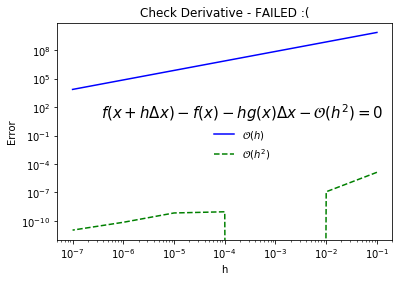

False

In [753]:
Tests.checkDerivative(vol_deriv, x0=x0, plotIt=False)

In [789]:
survey_vol.dobs = np.r_[V_frac]
survey_vol.std = 0.01
survey_vol.eps = 0
survey_vol.srcList = []

In [790]:
dmis_vol = DataMisfit.l2_DataMisfit(survey_vol)

In [791]:
x0 = np.random.rand(mapping_scemt.nP)
def vol_deriv(x):
    return dmis_vol(x), lambda h: np.inner(dmis_vol.deriv(x0), h)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    5.708e+18     9.670e+16      nan
 1   1.00e-02    5.795e+17     9.670e+14      2.000
 2   1.00e-03    5.803e+16     9.670e+12      2.000
 3   1.00e-04    5.804e+15     9.670e+10      2.000
 4   1.00e-05    5.804e+14     9.671e+08      2.000
 5   1.00e-06    5.804e+13     9.636e+06      2.002
========================= PASS! =========================
Awesome, Lindseyjh, just awesome.



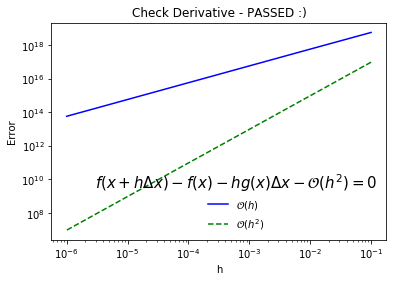

True

In [792]:
Tests.checkDerivative(vol_deriv, x0=x0, num=6, plotIt=False)

In [793]:
dmis_vol.deriv(x0, 0.001*np.ones_like(x0)).shape

(39658,)

In [806]:
reg_scemt_vol = Regularization.Tikhonov(
    regmesh, alpha_s=1e-3, alpha_x=1, indActive=~ind_inactive, mref=np.zeros(mapping_scemt.nP)
)
dmis_scemt_vol = DataMisfit.l2_DataMisfit(survey_scemt) + dmis_vol
opt_scemt_vol = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=30, remember='xc', lower=0., upper=1., stepOffBoundsFact=1e-4
)
invProb_scemt_vol = InvProblem.BaseInvProblem(dmis_scemt_vol, reg_scemt_vol, opt_scemt_vol)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt_vol = Inversion.BaseInversion(invProb_scemt_vol, directiveList=directives)

In [807]:
mrec_scemt_vol = inv_scemt_vol.run(m0_scemt)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the Problem3D_CC problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.87e+08  1.43e+03  1.17e-16  1.43e+03    1.88e+02      0              
   1  3.87e+08  1.28e+03  5.91e-15  1.28e+03    1.76e+02      0              
   2  3.87e+08  1.13e+03  2.18e-11  1.13e+03    1.18e+02      3   Skip BFGS  
   3  4.84e+07  1.07e+03  2.17e-11  1.07e+03    1.20e+02      0              
   4  4.84e+07  1.03e+03  2.15e-11  1.03e+03    1.24e+02      0   Skip BFGS  
   5  4.84e+07  1.03e+03  1.96e-10  1.03e+03    1.15e+02      2              
   6  6.04e+06  6.77e+02  1.98e-10  6.77e+02    1.18e+02      0              
   7  6.04e+06  4.56e+02  1.1

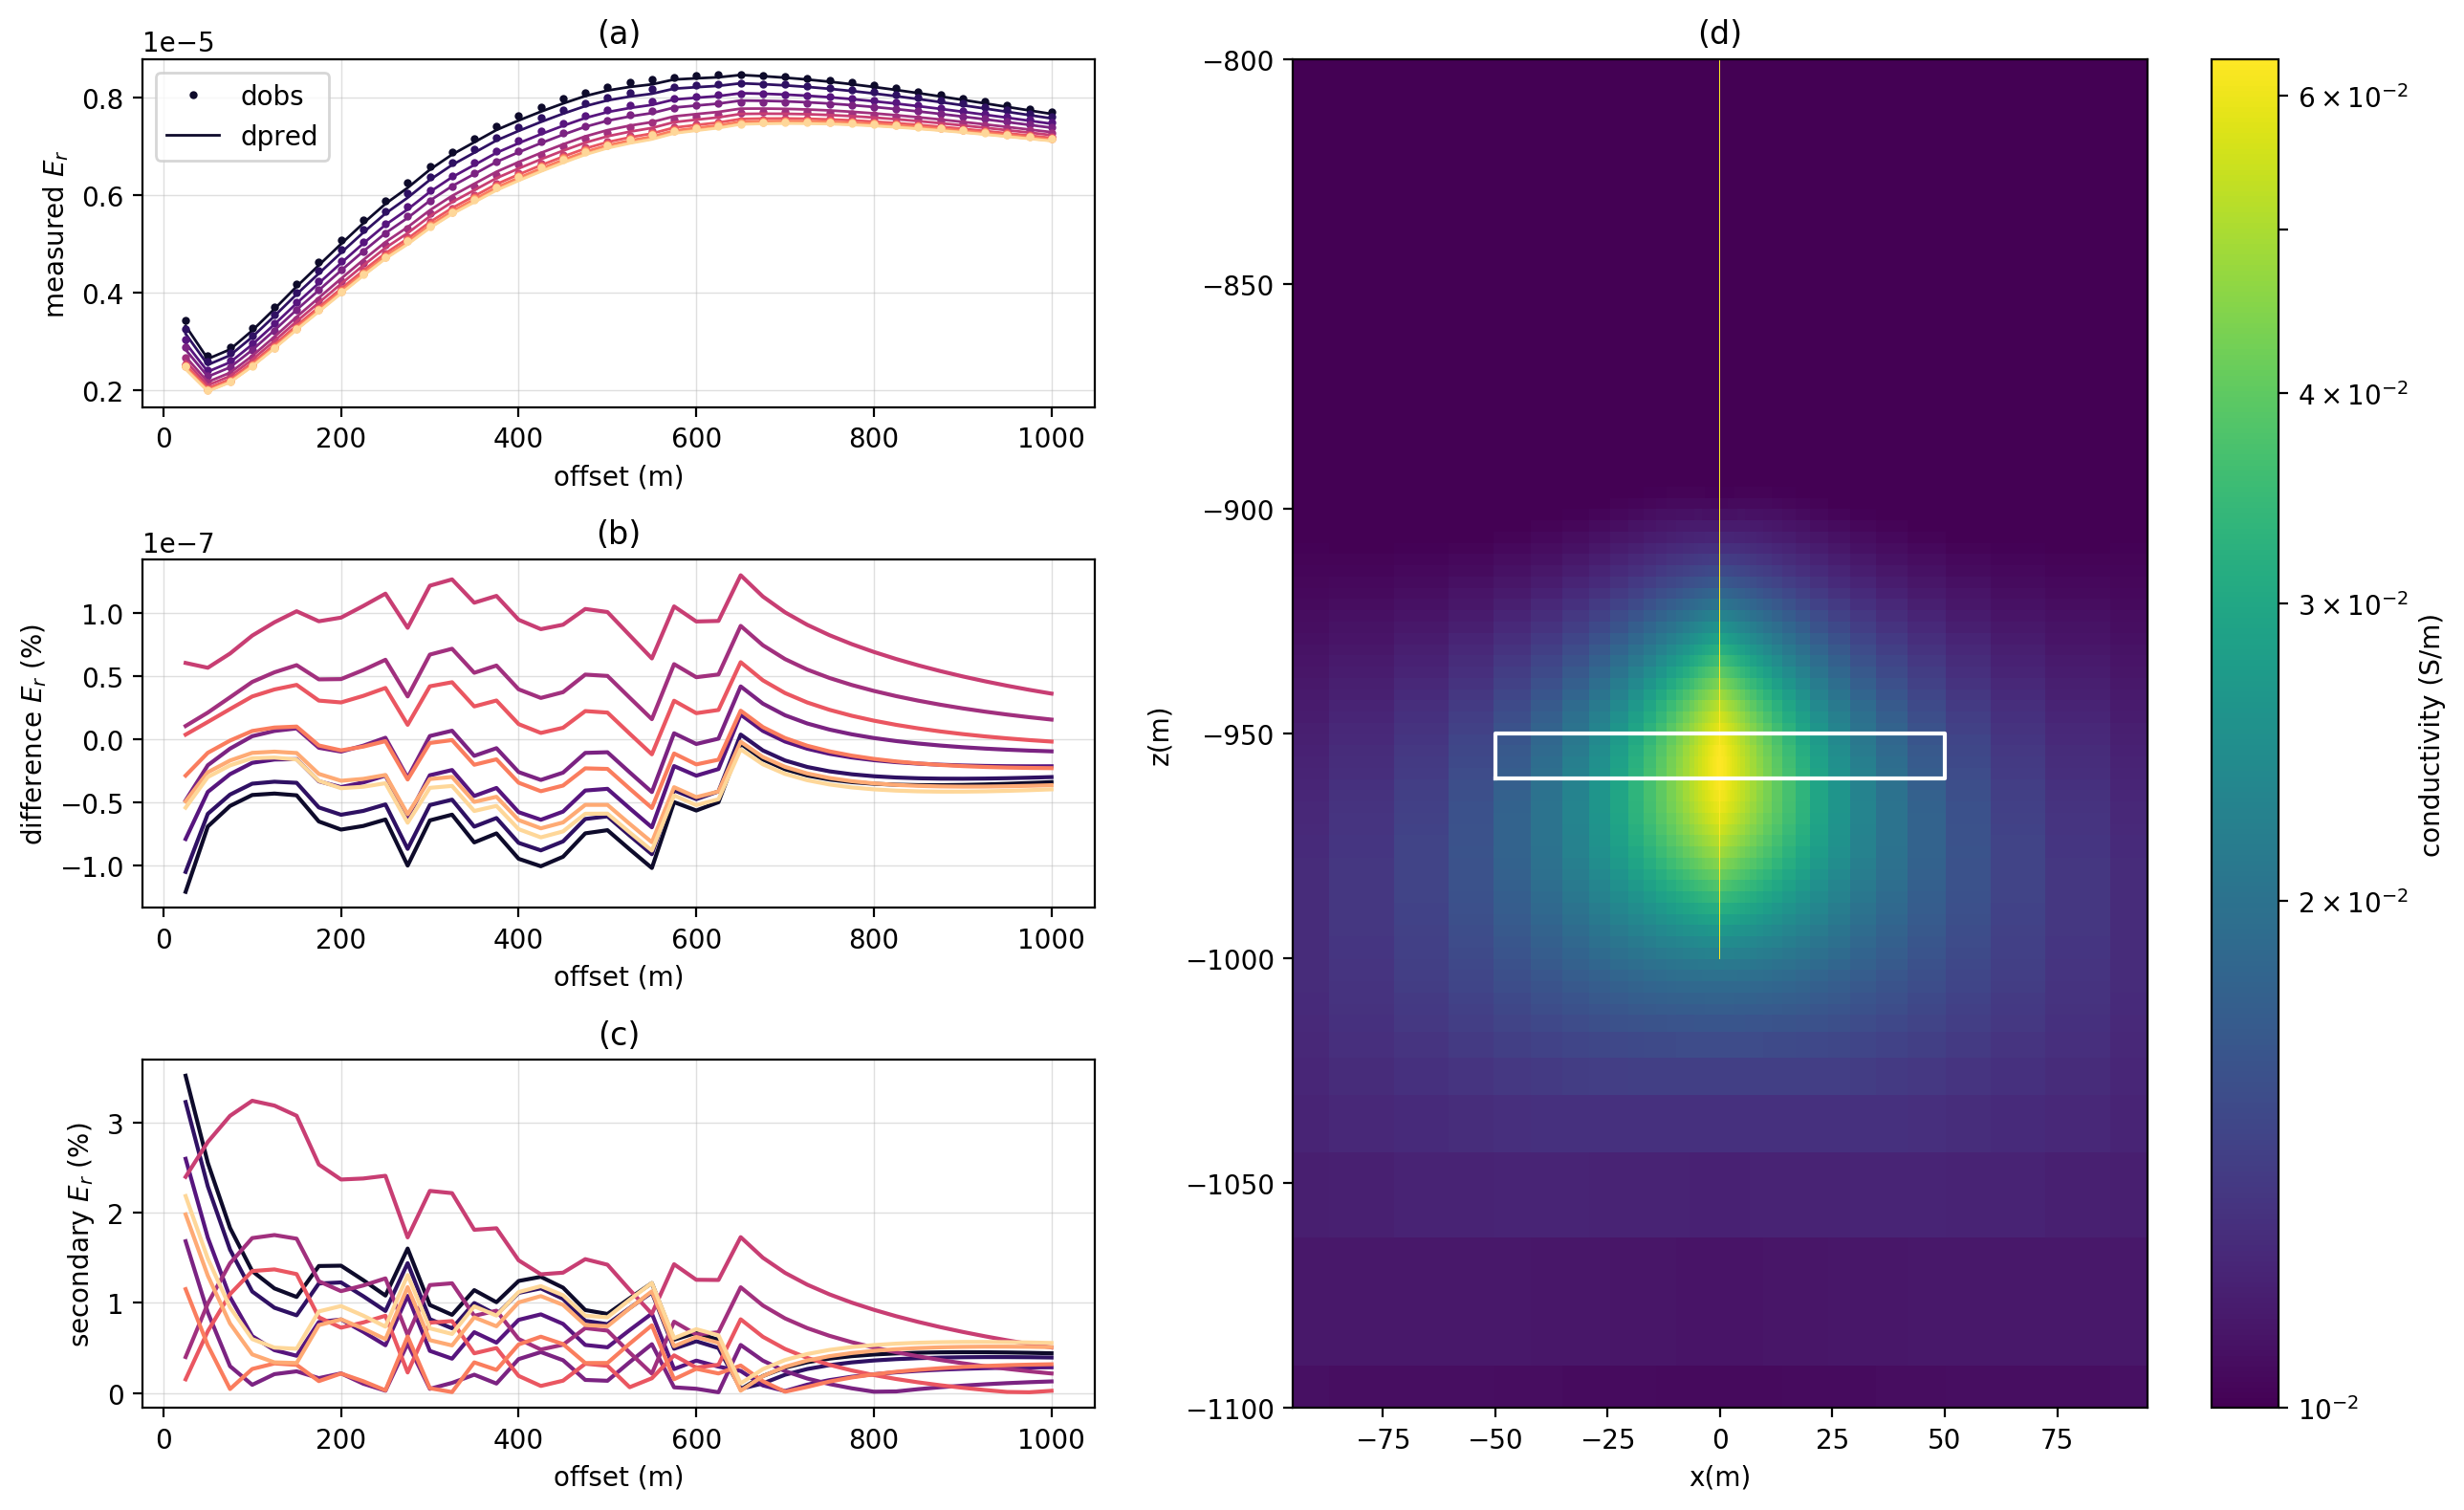

In [808]:
fig, ax, out = plot_inversion(invProb_scemt_vol.dpred[0],  mapping_scemt, mrec_scemt_vol, clim=np.r_[
    np.min(np.r_[sigma_back, (scemt_mapping * mrec_scemt_vol).min()]), 
    (scemt_mapping * mrec_scemt_vol).max()
])
# fig.savefig('../figures/dc_smooth_inversion_{:1.0e}'.format(CHIFACT), dpi=200)

### SCEMT + Parametric

In [ ]:
# mapping_parametric
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, np.log(sigma_inactive))
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=1e-1)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
indActiveX0[2] = False
InjectX0 = Maps.InjectActiveCells(
    discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
    valInactive=0.
)

indices_sigma = np.zeros(InjectX0.nP, dtype=bool)
indices_sigma[0:2] = True

SCEMT = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=2
)

sumMap = Maps.SumMap(
    [
        (
            Maps.InjectActiveCells(None, nC=InjectX0.nP, indActive=indices_sigma, valInactive=0) * 
            Maps.LogMap(nP=SCEMT.nP) * SCEMT * Maps.Projection(InjectX0.nP, indices_sigma)
        ),
        Maps.InjectActiveCells(None, nC=InjectX0.nP, indActive=~indices_sigma, valInactive=0) * Maps.Projection(InjectX0.nP, ~indices_sigma)
    ],
)

scemt_parametric_map = Maps.ExpMap(mesh) * InjectInactiveCells * ParametricBlock * InjectX0 * sumMap

# mapping_parametric = (
#     Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive) * ParametricBlock * InjectX0 * 
    
# )

In [ ]:
prob_scemt2, survey_scemt2 = get_prob_survey(scemt_parametric_map2)

In [925]:
reg_parametric = Regularization.Tikhonov(discretize.TensorMesh([scemt_parametric_map2.nP]))

dmis_scemt2 = DataMisfit.l2_DataMisfit(survey_scemt2)
opt_scemt2 = Optimization.ProjectedGNCG(
    maxIterCG=10, maxIter=10, remember='xc', 
    lower=np.hstack([2*[0.], 2*[-np.inf]]), upper=np.hstack([2*[1.], 2*[np.inf]]), stepOffBoundsFact=1e-4
)
invProb_scemt2 = InvProblem.BaseInvProblem(dmis_scemt2, reg_parametric, opt_scemt2, beta=0)
directives = [
#     Directives.BetaEstimate_ByEig(beta0_ratio=10),
#     Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_scemt2 = Inversion.BaseInversion(invProb_scemt2, directiveList=directives)

In [926]:
m0_scemt_parametric = np.hstack([np.r_[1e-10, 1e-4], m0_parametric[2:]])

In [927]:
m0_scemt_parametric

array([1.e-10, 1.e-04, 1.e+01, 1.e+01])

(array([<matplotlib.axes._subplots.AxesSubplot object at 0xe40eea208>,
       dtype=object),
 (<matplotlib.collections.QuadMesh at 0xe4028a278>,
  <matplotlib.colorbar.Colorbar at 0xe40f4c518>),
 (<matplotlib.collections.QuadMesh at 0xe40f6df98>,
  <matplotlib.colorbar.Colorbar at 0xe3fb83860>))

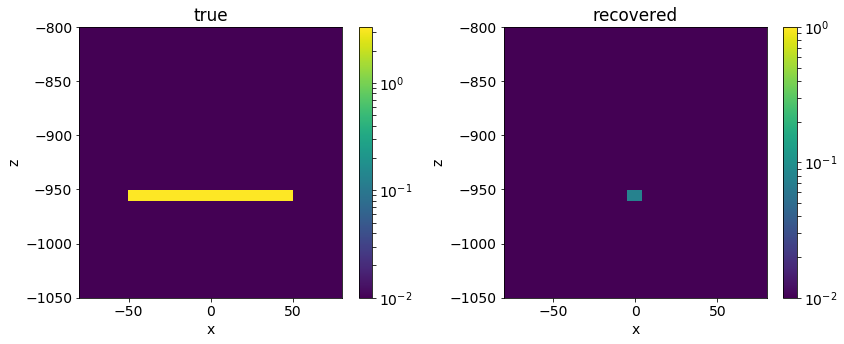

In [928]:
plot_models(m0_scemt_parametric, scemt_parametric_map2, clim=np.r_[sigma_back, 1])

In [929]:
# scemt_parametric_map2.test(m0_scemt_parametric, dx=np.r_[1e-6, 0, 0, 0, 0])

In [930]:
mrec_scemt_parametric = inv_scemt2.run(m0_scemt_parametric)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  8.75e+02  2.00e+02  8.75e+02    2.30e+00      0              
   1  0.00e+00  8.14e+01  2.00e+02  8.14e+01    1.43e+00      0              
   2  0.00e+00  7.94e+01  2.00e+02  7.94e+01    1.01e+00      0   Skip BFGS  
   3  0.00e+00  7.07e+01  2.00e+02  7.07e+01    1.55e+00      3   Skip BFGS  
   4  0.00e+00  6.87e+01  2.00e+02  6.87e+01    1.08e+00      0              
   5  0.00e+00  5.66e+01  2.42e+03  5.66e+01    2.58e+00      0   Skip BFGS  
   6  0.00e+00  5.56e+01  2.42e+03  5.56e+01    2.61e+00      0   

In [931]:
mrec_scemt_parametric

array([5.53908390e-07, 1.34449419e-03, 4.46097955e+01, 2.62040599e+01])

(array([<matplotlib.axes._subplots.AxesSubplot object at 0xe41c6eb00>,
       dtype=object),
 (<matplotlib.collections.QuadMesh at 0xe3e102518>,
  <matplotlib.colorbar.Colorbar at 0xe3d0583c8>),
 (<matplotlib.collections.QuadMesh at 0xe0b42dc88>,
  <matplotlib.colorbar.Colorbar at 0xdf4ad2d68>))

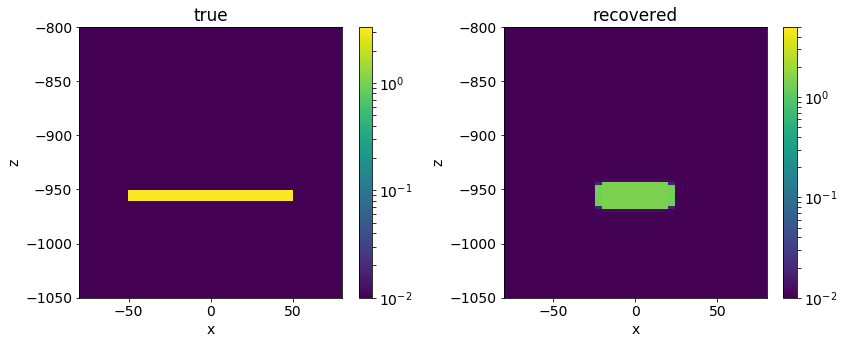

In [932]:
plot_models(mrec_scemt_parametric, scemt_parametric_map2, clim=np.r_[sigma_back, 5])

## different order of operations (convert to phi on the mesh) 

In [ ]:
# mapping_parametric
ind_inactive = (
    (mesh.gridCC[:,2] > 0) | 
    (
        (mesh.gridCC[:, 0] <= model.casing_b) & 
        (mesh.gridCC[:, 2] >= model.casing_z.min()) &
        (mesh.gridCC[:, 2] <= model.casing_z.max())
    )
)
sigma_inactive = phys_props_dict["background"].sigma[ind_inactive]
InjectInactiveCells = Maps.InjectActiveCells(mesh, ~ind_inactive, sigma_inactive)
ParametricBlock = Maps.ParametricBlock(regmesh, indActive=~ind_inactive, slopeFact=1)
indActiveX0= np.ones(ParametricBlock.nP, dtype=bool)
# indActiveX0[2] = False
# InjectX0 = Maps.InjectActiveCells(
#     discretize.TensorMesh([np.ones(ParametricBlock.nP)]), indActive=indActiveX0,
#     valInactive=0.
# )

SCEMT2 = Maps.SelfConsistentEffectiveMedium(
    sigma0=sigma_back, sigma1=sigma_pf, alpha1=alpha, nP=(~ind_inactive).sum()
)


scemt_parametric_map2 = InjectInactiveCells * SCEMT2 * ParametricBlock * InjectX0


## Include the volume term

In [ ]:
class ParametricVolume(Problem.BaseProblem):
    # surveyPair = Survey.LinearSurvey
    
    phi, phi_map, phi_deriv = Props.Invertible(
        "concentration (unitless)"
    )
    
    dx, dx_map, dx_deriv = Props.Invertible(
        "width in the x-dimension of the target"
    )
    
    dy, dy_map, dy_deriv = Props.Invertible(
        "width in the y-dimension of the target"
    )
    
    dz, dz_map, dz_deriv = Props.Invertible(
        "width in the z-dimension of the target"
    )
    
    def __init__(self, **kwargs):
        BaseProblem.__init__(self, None, **kwargs)

    def fields(self, m):
        return  self.dx * self.dy * self.dz * self.phi

    def Jvec(self, m, v, f=None):
        return (
            self.dx * self.dy * self.dz * (self.phi_deriv * v) +
            self.dx * self.dy * self.phi * (self.dz_deriv * v) +
            self.dx * self.phi * self.dz * (self.dy_deriv * v) +
            self.phi * self.dy * self.dz * (self.dz_deriv * v)
        )
            
    def Jtvec(self, m, v, f=None):
        return (
            self.dx * self.dy * self.dz * (self.phi_deriv.T * v) +
            self.dx * self.dy * self.phi * (self.dz_deriv.T * v) +
            self.dx * self.phi * self.dz * (self.dy_deriv.T * v) +
            self.phi * self.dy * self.dz * (self.dz_deriv.T * v)
        )


In [ ]:
vol_prob = Volume(mesh, phi_map=)

In [ ]:
x = np.linspace(-1, 1, 100)

plt.plot(x, np.abs(x/0.5, 1)

In [ ]:
SCEMT * np.r_[phi_frac, mrec_scemt_parametric[1]]

## L2 inversion on uniformly spaced mesh

In [50]:
casing_region = regmesh.hx[regmesh.hx < cylMeshGen.csz].sum()
ncells = int(np.ceil(casing_region/cylMeshGen.csz))
casing_region_h = np.ones(ncells) * casing_region/ncells

regmesh2 = discretize.TensorMesh(
    [
        np.hstack([casing_region_h, regmesh.hx[regmesh.hx >= cylMeshGen.csz]]), 
        regmesh.hy[regmesh.vectorCCy <= 0]
    ],
    x0=np.r_[0., -regmesh.hy[regmesh.vectorCCy <= 0].sum()]
)


In [ ]:
mesh2mesh = Maps.Mesh2Mesh([regmesh, regmesh2], indActive = np.where(~ind_inactive)[0])
mapping2 = ExpMap * InjectInactiveCells * mesh2mesh

In [ ]:
prob_inv2, survey_inv2 = get_prob_survey(mapping2)

In [ ]:
reg2 = Regularization.Tikhonov(regmesh2, alpha_s=1e-3)
dmis2 = DataMisfit.l2_DataMisfit(survey_inv2)
opt2 = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=5, remember='xc')
invProb2 = InvProblem.BaseInvProblem(dmis2, reg2, opt2)
directives = [
    Directives.BetaEstimate_ByEig(beta0_ratio=10),
    Directives.BetaSchedule(coolingFactor=8, coolingRate=3),
#     Directives.SaveOutputEveryIteration(),
#     Directives.SaveModelEveryIteration(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv2 = Inversion.BaseInversion(invProb2, directiveList=directives)

In [ ]:
m02 = np.ones(regmesh2.nC) * np.log(sigma_back)

In [ ]:
%%time
mrec2 = inv2.run(m02)

In [ ]:
plot_models(mrec2, mapping2, xlim=80*np.r_[-1, 1])

In [ ]:
dpred2 = invProb2.dpred.reshape(len(rx_x), len(src_list), order="F")
plot_data(data_dict["fracture"], dpred2)

## sparse inversion

In [817]:
# regmesh = discretize.TensorMesh([mesh.hx, mesh.hz], x0=np.r_[mesh.x0[[0, 2]]])
# reg = Regularization.Tikhonov(regmesh, alpha_s=1e-1, indActive=~ind_inactive)
reg_sparse = Regularization.Sparse(
    regmesh, indActive=~ind_inactive,
    gradientType='components', 
    mapping=Maps.IdentityMap(nP=(~ind_inactive).sum()),
    alpha_s=1e-3, alpha_x=100
)
reg_sparse.cell_weights = regmesh.vol[~ind_inactive]
#     gradientType = 'components'
reg_sparse.norms = np.c_[0., 2., 2., 2.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1,
    betaSearch=True, fix_Jmatrix=False, 
    chifact_start=CHIFACT, beta_ratio_l2=10, 
    coolingFactor=8, coolingRate=3
)
# update_sensitivity = Directives.UpdateSensitivityWeights(threshold=1e-3)
dmis_sparse = DataMisfit.l2_DataMisfit(survey_inv)
opt_sparse = Optimization.InexactGaussNewton(maxIterCG=10, maxIter=10, remember='xc')
invProb_sparse = InvProblem.BaseInvProblem(dmis_sparse, reg_sparse, opt_sparse)
directives_sparse = [
    IRLS,
#     update_sensitivity, 
#     Directives.UpdatePreconditioner(),
    Directives.TargetMisfit(chifact=CHIFACT)
]
inv_sparse = Inversion.BaseInversion(invProb_sparse, directiveList=directives_sparse)

/Users/lindseyjh/git/python_symlinks/SimPEG/Directives.py:886: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


In [818]:
%%time
mrec_sparse = inv_sparse.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.28e+03  0.00e+00  1.28e+03    5.97e+02      0              
   1  1.00e+00  7.42e+01  1.95e+01  9.37e+01    6.93e+01      0              
   2  1.00e+00  4.03e+01  3.41e+01  7.44e+01    4.33e+00      0   Skip BFGS  
   3  1.25e-01  4.12e+01  3.27e+01  4.53e+01    2.93e+01      0              
   4  1.25e-01  1.52e+01  1.09e+02  2.88e+01    1.13e+01      0              
   5  1.25e-01  1.43e+01  1.08e+02  2.79e+01    6.85e+00      0              
   6  1.56e-02  1.31e+01  1.16e+02  1.49e+01    1.07e+01      0   

/Users/lindseyjh/git/python_symlinks/SimPEG/Directives.py:763: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


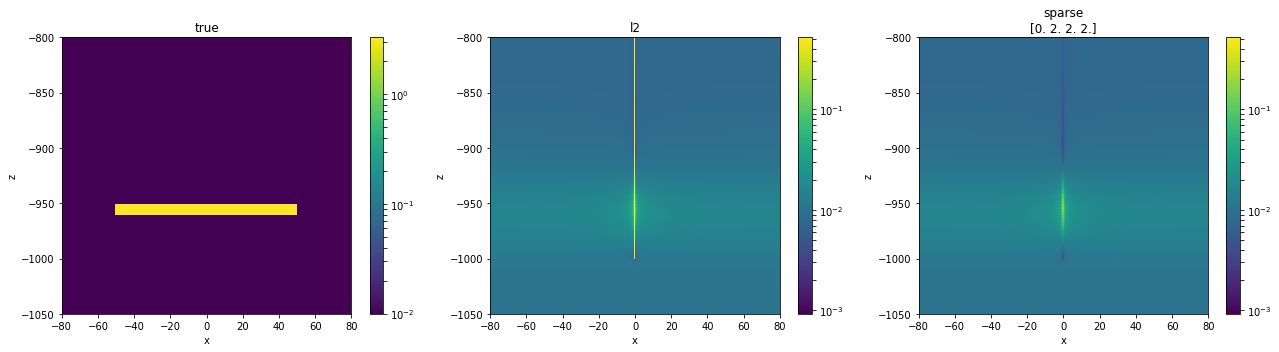

In [819]:
fig, ax = plt.subplots(1, 3, figsize=(6*3, 5))
xlim = 80*np.r_[-1, 1]
ylim = [-1050, -800]
clim = [np.min(np.r_[sigma_back, np.exp(mrec_sparse.min())]), np.exp(mrec_sparse.max())]
plot_mesh = False

out_true = phys_props_dict[key].plot_sigma(
    ax=ax[0], pcolorOpts={'norm':LogNorm()}, clim=np.r_[sigma_back, sigma_frac]
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * invProb_sparse.l2model, ax=ax[1], pcolorOpts={'norm':LogNorm()}, clim=clim
)
out_rec = phys_props_dict[key].plot_prop(
    mapping * mrec_sparse, ax=ax[2], pcolorOpts={'norm':LogNorm()}, clim=clim
)

for a, title in zip(ax, ["true", "l2", "sparse\n{}".format(reg_sparse.norms[0, :])]):
    a.set_xlim(xlim)
    a.set_ylim(ylim)
    a.set_title(title)

    if plot_mesh:
        mesh.plotGrid(ax=a, line_width=0.1, line_color='k', slice="theta")
        a.grid(None)

plt.tight_layout()

In [ ]:
dpred_sparse = invProb_sparse.dpred.reshape(len(rx_x), len(src_list), order="F")
plot_data(data_dict["fracture"], dpred_sparse)